# Final figures for Sawi et al. 2023 

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('src/')
from notebook_functions import calcRadius, haversine
import pygmt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import glob
from notebook_functions import plotScatterMapDepthAlongStrike,formatWS2021,plotScatterMap,calcDfRID2Stats,calcDfStats2
from notebook_functions import plotCumul3, plotScatterMap, plotScatterMapDepth,calcMom,latlon2meter,upper_tri_masking,calcDfStats2,calcDfStats,getWF,lagWF,plotClusWF6, plotStem5,calcCCMatrix
from notebook_functions import plotLocZoomMeters, plotDepthZoomMeters, plotStem4,plotLocZoom5,plotDepthZoom8,calcCCMatrix,plotCCDistancesfromMat,plotClusWF6, calcCCMatrixFP,getYearlyMedianSlipRate
from notebook_functions import GradeLocErrorLatLon, GradeLocErrorMeters, plotLocLatLonError, plotScatterMapDepthAlongStrike, calcDfRID2Stats,plotCumulMoment,    getYearlyCount, getYearlyMedianMag, removeEndedRES3
from notebook_functions import plotMedianBins,plotCircle, formatWS2021, getProportionWS21,removeEndedRES,removeEndedRES2,meters2deg
from notebook_functions import calcMom, plotCumul4, rotateMapView, removeEndedLateRES, removeEndedLateRES_RID, plotScatterMapRID_basic, plotScatterMapRID, rotateMapView, plotScatterMapDepthAlongStrikeRID, plotCumul5, plotCumulMoment
from matplotlib.gridspec import GridSpec



from matplotlib import cm
from scipy.interpolate import RectBivariateSpline, interp2d

from matplotlib.lines import Line2D
import cartopy.crs as ccrs
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as path_effects
import rasterio
from scipy import stats


from matplotlib import pyplot as plt



# Initial catalogs

In [3]:
cat_NCSN = pd.read_csv('../data/catalogs/NCADDiff_5km_2019_500mFault.csv')

cat_NCSN['timestamp'] = pd.to_datetime(cat_NCSN[['year','month','day','hour','minute','second']])
cat_NCSN['timestamp_index'] = pd.to_datetime(cat_NCSN[['year','month','day','hour','minute','second']])
cat_NCSN = cat_NCSN.set_index('timestamp_index')



cat_WS21 = cat_NCSN[cat_NCSN.RID!='0']

# Relocated catalog April 2023

In [4]:
R_Remove = ['R0.0471.11019.0',
'R0.0819.3997.0',
'R0.0814.4048.0', 
'R0.0817.4012.0',
'R1.3146.11438.0',
'R1.6962.1572.0',
'R1.2726.1568.0.C',
'R1.6826.2156.0',
'R1.6771.2335.0',
'R1.7285.58.0']


cols = ['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC',\
'magnitude', 'NCCP', 'NCCS', 'NCTP','NCTS', 'RCC', 'RCT', 'RID']
R_list = np.unique(cat_WS21.RID)
hypo_cat_all = []

for RR in R_list:
    if RR not in R_Remove:

        path_hypocat = f'../data/catalogs/RES_relocfiles/hypoDD.reloc.{RR}'
        hypo_cat = pd.read_csv(path_hypocat,delim_whitespace=True,header=None,names=cols)
        hypo_cat['RID'] = RR
        hypo_cat['Cluster_2'] = RR

        hypo_cat_all.append(hypo_cat)

cat_WS21_reloc = pd.concat(hypo_cat_all,ignore_index=True)
    
cat_WS21_reloc['year'] = cat_WS21_reloc['YR']
cat_WS21_reloc['month']= cat_WS21_reloc['MO'] 
cat_WS21_reloc['day']= cat_WS21_reloc['DY']
cat_WS21_reloc['hour']= cat_WS21_reloc['HR']
cat_WS21_reloc['minute']= cat_WS21_reloc['MI']
cat_WS21_reloc['second']= cat_WS21_reloc['SC']

cat_WS21_reloc['timestamp'] = pd.to_datetime(cat_WS21_reloc[['year','month','day','hour','minute','second']])
cat_WS21_reloc['timestamp_index'] = pd.to_datetime(cat_WS21_reloc[['year','month','day','hour','minute','second']])
cat_WS21_reloc = cat_WS21_reloc.set_index('timestamp_index')
cat_WS21_reloc = cat_WS21_reloc[cat_WS21_reloc.event_ID.isin(cat_WS21.event_ID)]

cat_WS21_reloc['numEvents'] = [len(cat_WS21_reloc[cat_WS21_reloc.RID==clus]) for clus in cat_WS21_reloc.RID]


FileNotFoundError: [Errno 2] No such file or directory: '../data/catalogs/RES_relocfiles/hypoDD.reloc.R0.0031.4042.0'

# Load Felix-checked UPDATED clusters

In [5]:
cols = ['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC',\
'magnitude', 'NCCP', 'NCCS', 'NCTP','NCTS', 'RCC', 'RCT', 'RIDX']

files = glob.glob('../data/catalogs/relocfiles_RES2019_DD2021/*')
files.sort()
upddated_list = []

for fi in files:
    R = fi.split('/')[-1][13:]
#     print(R)
    updated_temp = pd.read_csv(fi,delim_whitespace=True,header=None,names=cols)  
    updated_temp['RID2'] = R     
    upddated_list.append(updated_temp)

cat_updated_raw = pd.concat(upddated_list,ignore_index=True)

cat_updated_raw['year'] = cat_updated_raw['YR']
cat_updated_raw['month']= cat_updated_raw['MO'] 
cat_updated_raw['day']= cat_updated_raw['DY']
cat_updated_raw['hour']= cat_updated_raw['HR']
cat_updated_raw['minute']= cat_updated_raw['MI']
cat_updated_raw['second']= cat_updated_raw['SC']

cat_updated_raw['timestamp'] = pd.to_datetime(cat_updated_raw[['year','month','day','hour','minute','second']])
cat_updated_raw['timestamp_index'] = pd.to_datetime(cat_updated_raw[['year','month','day','hour','minute','second']])
cat_updated_raw = cat_updated_raw.set_index('timestamp_index')



In [6]:
isInWS21 = []
isUpdatedNew = []
list_RID = []

for i,ev in enumerate(cat_updated_raw.event_ID):
    if int(ev) in list(cat_WS21_reloc.event_ID):
        isInWS21.append(1)
        isUpdatedNew.append(0)
    else:
        isInWS21.append(0)
        isUpdatedNew.append(1)
        
cat_updated_raw['isInWS21'] = isInWS21
cat_updated_raw['isUpdated'] = 1
cat_updated_raw['isUpdatedNew'] = isUpdatedNew
cat_updated_raw['isAllNew'] = 0

len(cat_updated_raw),len(cat_updated_raw[cat_updated_raw.isInWS21==1])

(1228, 785)

# Get Felix-relocated and checked NEW sequences

In [7]:
cols = ['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC',\
'magnitude', 'NCCP', 'NCCS', 'NCTP','NCTS', 'RCC', 'RCT', 'RID']

files = glob.glob('../data/catalogs/relocfiles_NEWRES2019_DD2021/*')
new_list = []

for fi in files:
    R = fi.split('/')[-1][13:]
    if 'r' not in R and '10147' not in R: ## little 'r' means remove that sequence
        new_temp = pd.read_csv(fi,delim_whitespace=True,header=None,names=cols)  
        new_temp['RID2'] = R 
        new_temp['isInWS21'] = 0                
        new_list.append(new_temp)

cat_new = pd.concat(new_list,ignore_index=True)

cat_new['year'] = cat_new['YR']
cat_new['month']= cat_new['MO'] 
cat_new['day']= cat_new['DY']
cat_new['hour']= cat_new['HR']
cat_new['minute']= cat_new['MI']
cat_new['second']= cat_new['SC']

cat_new['timestamp'] = pd.to_datetime(cat_new[['year','month','day','hour','minute','second']])
cat_new['timestamp_index'] = pd.to_datetime(cat_new[['year','month','day','hour','minute','second']])
cat_new = cat_new.set_index('timestamp_index')

cat_new['isUpdated'] = 0
cat_new['isAllNew'] = 1
cat_new['RID'] = '0'
cat_new['isNew'] = 1

len(cat_new), len(cat_new.drop_duplicates('RID2'))

(903, 199)

# 54 Missing events in Felix reloc catalog; why? 
## They are just on the boundary of the study region, except one, not sure why that one was missed! 
## We leave them out because they were not put through the criteria test

54 missing events
['R1.0278.1185.0' 'R1.0778.697.0.C.R' 'R1.0912.4487.0.C' 'R1.0965.2633.0.C']


(54, 54)

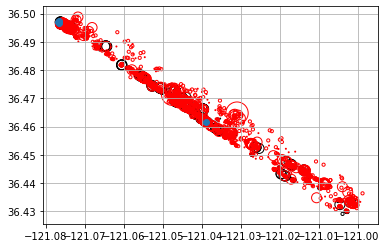

In [8]:
cat_missing_orig = cat_updated_raw[~cat_updated_raw.event_ID.isin(cat_NCSN.event_ID.astype('str'))]
print(len(cat_missing_orig), 'missing events')

cat_missing_orig['RID'] = [r[:-2] for r in cat_missing_orig['RID2']]


plt.figure()
ax = plt.gca()
plotScatterMap(cat_NCSN,ax=ax)
ax.scatter(cat_missing_orig.drop_duplicates('RID2').long,cat_missing_orig.drop_duplicates('RID2').lat)
print(cat_missing_orig['RID'].unique())


len(cat_missing_orig), len(cat_missing_orig.drop_duplicates('event_ID'))

In [9]:
# Add issing ones back just to get RIDs
# cat_WS21_reloc_pm = pd.concat([cat_WS21_reloc,cat_missing])
cat_NCSN_pm = pd.concat([cat_NCSN,cat_missing_orig])

In [10]:

RID_list = []

for ev in cat_updated_raw.event_ID.astype('int'):
    
    catNC_ev = cat_NCSN_pm[cat_NCSN_pm.event_ID==ev]
    
#     print(len(catNC_ev))

    R = list(catNC_ev.RID)[0]
    
    RID_list.append(R)

cat_updated_raw['RID'] =  RID_list

cat_updated_raw.RID.replace(to_replace='9999',value='0',inplace=True)

len(cat_updated_raw), len(cat_updated_raw.drop_duplicates('event_ID'))

(1228, 1228)

# Combine new and updated catalog


In [11]:
# Combine new and updated catalog
cat_new_updated = pd.concat([cat_updated_raw,cat_new])
len(cat_new_updated), len(cat_new_updated.drop_duplicates('event_ID'))

(2131, 2131)

# Add missing RIDS from WS21

3 repeaters have lost their cluster, so just remove those


In [12]:
missing_RID_df = cat_WS21_reloc[~cat_WS21_reloc.event_ID.isin(list(cat_new_updated.event_ID.astype('str')))]

#Temporary naming
missing_RID_df['RID2'] = missing_RID_df['RID'].copy() 
missing_RID_df['numEvents'] = [len(missing_RID_df[missing_RID_df.RID2==clus]) for clus in missing_RID_df.RID2]

missing_RID_df.RID = [str(r) + '.R.u' if numEv == 1 else str(r) for r, numEv in zip(missing_RID_df.RID, missing_RID_df.numEvents)]

missing_RID_df.RID2 = missing_RID_df.RID
missing_RID_df['isUpdated'] = 0
missing_RID_df['isAllNew'] = 0


print(len(missing_RID_df), 'events were not found by our method')
print(len(np.unique(missing_RID_df.RID2)), 'sequences were not found by our method')



len(missing_RID_df), len(missing_RID_df.drop_duplicates('event_ID'))

210 events were not found by our method
49 sequences were not found by our method


(210, 210)

### Add missing RIDs from WS21 if the complete sequence was not found through this study. If part of a sequence but not the whole thing was added, then drop the remaining partial sequence

In [13]:
missing_RID_df = cat_WS21_reloc[~cat_WS21_reloc.event_ID.isin(list(cat_new_updated.event_ID.astype('str')))]
len(missing_RID_df)

210

In [14]:
cat_missing_RES_list = []

for r in cat_WS21_reloc.RID.unique():
    
    if str(r) + '.u'  not in list(cat_new_updated.RID2) and str(r) + '.R.u'  not in list(cat_new_updated.RID2):
        
        df_m = cat_WS21_reloc[cat_WS21_reloc.RID==r]
        
        df_m_trim = df_m[~df_m.event_ID.isin(list(cat_new_updated.event_ID.astype('int')))]
        
        df_m_trim['RID2'] =  df_m_trim['RID']
        
        cat_missing_RES_list.append(df_m_trim)
        
        
        
        
        
        
        
cat_missing_RES = pd.concat(cat_missing_RES_list)#.drop_duplicates('event_ID')
        
#     cat_new_updated




In [15]:
len(cat_missing_RES), len(cat_missing_RES.drop_duplicates('event_ID'))

(196, 196)

In [16]:
cat_all = pd.concat([cat_new_updated,cat_missing_RES])
len(cat_all), len(cat_all.drop_duplicates('event_ID'))
cat_all['numEvents'] = [len(cat_all[cat_all.RID2==clus]) for clus in cat_all.RID2]


In [17]:
lat0,lon0 = np.mean(cat_all.lat),-121.04#np.mean(cat2_stats.long)

cat_all['dist_along_strike_km']  = rotateMapView(cat_all,48+90,lat0,lon0)
cat_NCSN['dist_along_strike_km']  = rotateMapView(cat_NCSN,48+90,lat0,lon0)

# Results

In [18]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(len(cat_all.drop_duplicates('event_ID')), ' total repeating earthquakes from this study')
print(len(cat_all.drop_duplicates('RID2')), ' total RES from this study \n')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2327  total repeating earthquakes from this study
329  total RES from this study 



In [19]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(len(cat_all.drop_duplicates('event_ID')), ' total repeating earthquakes from this study')
print(len(cat_all.drop_duplicates('RID2')), ' total RES from this study \n')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2327  total repeating earthquakes from this study
329  total RES from this study 



In [20]:
print(len(cat_all[cat_all.isAllNew==1].drop_duplicates('RID2')), ' NEW RES from this study \n')

print(len(cat_all[cat_all.isUpdated==1].drop_duplicates('RID2')), ' UPDATED RES from this study \n')


199  NEW RES from this study 

89  UPDATED RES from this study 



In [21]:
print(len(cat_all[cat_all.isAllNew==1][cat_all.year<2015].drop_duplicates('RID2')), ' NEW RES from this study before 2014 \n')

print(len(cat_all[cat_all.isUpdated==1][cat_all.year<2015].drop_duplicates('RID2')), ' UPDATED RES from this study before 2014\n')


158  NEW RES from this study before 2014 

89  UPDATED RES from this study before 2014



In [22]:
len(cat_all)

2327

In [23]:
# print(len(cat_NCSN_pm), ' earthquakes \n', len(cat_WS21), ' WS21 repeating earthquakes')
# print(len(cat_WS21_reloc_pm), ' WS21 repeating earthquakes after relocation \n')

print(len(cat_NCSN), ' earthquakes \n', len(cat_WS21), ' WS21 repeating earthquakes')
print(len(cat_WS21_reloc), ' WS21 repeating earthquakes after relocation \n')


print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(len(cat_all), ' total repeating earthquakes from this study')
print(len(cat_all.drop_duplicates('RID2')), ' total RES from this study \n')

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(len(cat_all[cat_all.isAllNew==1].drop_duplicates('RID2')), ' NEW RES from this study \n')

print(len(cat_all[cat_all.isUpdated==1].drop_duplicates('RID2')), ' UPDATED RES from this study \n')

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
cat_all_2014 = cat_all[cat_all.year<=2014]


print(len(cat_NCSN[cat_NCSN.year<2015]), ' earthquakes up to the end of 2014')

print(len(cat_all_2014), ' total repeating earthquakes from this study BEFORE 2014')
print(len(cat_all_2014.drop_duplicates('RID2')), ' total RES from this study BEFORE 2014 \n')


print(len(cat_all_2014[cat_all_2014.isAllNew==1]), ' NEW repeating earthquakes from this study UP TO the end of  2014')
print(len(cat_all_2014[cat_all_2014.isAllNew==1].drop_duplicates('RID2')), ' NEW RES from this study UP TO the end of  2014 \n')

print(len(cat_all_2014[cat_all_2014.isUpdated==1]), ' UPDATED repeating earthquakes from this study BEFORE 2014')
print(len(cat_all_2014[cat_all_2014.isUpdated==1].drop_duplicates('RID2')), ' UPDATED RES from this study UP TO the end of  2014 \n')




3968  earthquakes 
 1024  WS21 repeating earthquakes
995  WS21 repeating earthquakes after relocation 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2327  total repeating earthquakes from this study
329  total RES from this study 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
199  NEW RES from this study 

89  UPDATED RES from this study 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3481  earthquakes up to the end of 2014
2102  total repeating earthquakes from this study BEFORE 2014
288  total RES from this study BEFORE 2014 

759  NEW repeating earthquakes from this study UP TO the end of  2014
158  NEW RES from this study UP TO the end of  2014 

1147  UPDATED repeating earthquakes from this study BEFORE 2014
89  UPDATED RES from this study UP TO the end of  2014 



In [24]:
print(len(cat_WS21_reloc.drop_duplicates('RID')[cat_WS21_reloc.drop_duplicates('RID').numEvents==2]),'doublets in WS21')
print(len(cat_all.drop_duplicates('RID2')[cat_all.drop_duplicates('RID2').numEvents==2]),'doublets in cat_all')
print(len(cat_all[cat_all.year<2015].drop_duplicates('RID2')[cat_all[cat_all.year<2015].drop_duplicates('RID2').numEvents==2]),'doublets in cat_all UP TO 2014')

18 doublets in WS21
85 doublets in cat_all
55 doublets in cat_all UP TO 2014


# Cat RESp

In [30]:

def removeEndedLateRES(cat, endYear = 2015):
    
    startYear = 1984
    
    cat_reloc_graded_stats_cont = pd.DataFrame()

    for cl in np.unique(cat.RID2):
        df_cl = cat[cat.RID2==cl].copy()

        time_mean = df_cl.time_mean_yr.iloc[0] *3

        time_end = df_cl.index[-1] 
        time_start = df_cl.index[0] 
        

        if ((time_end.date()+pd.Timedelta(time_mean*365.25,'day')).year >= endYear) and ((time_start.date()-pd.Timedelta(time_mean*365.25,'day')).year <= startYear):



            cat_reloc_graded_stats_cont = cat_reloc_graded_stats_cont.append(df_cl)

        
#     print(len(cat),len(cat_reloc_graded_stats_cont))
    print(len(cat)-len(cat_reloc_graded_stats_cont), ' events removed')        
    
    return cat_reloc_graded_stats_cont  


In [31]:
# Temporal culling

cat2_stats = calcDfRID2Stats(cat_all,timeMin=1/12)
cat2_stats_cont = removeEndedLateRES(cat2_stats,endYear=2020) 

cat2_stats_cont = cat2_stats_cont[cat2_stats_cont.numEvents>2].copy()


cat1_stats = calcDfStats2(cat_WS21_reloc,timeMin=1/12)
cat1_stats_cont = removeEndedLateRES_RID(cat1_stats,endYear=2015)

cat1_stats_cont = cat1_stats_cont[cat1_stats_cont.numEvents>2].copy()

0/329
50/329
100/329
150/329
200/329
250/329
300/329
2327 2238
792  events removed
0/134
50/134
100/134
995 966
966 828
138  events removed


In [32]:
print(len(cat2_stats_cont),len(cat1_stats_cont))

1388 816


In [33]:


print(len(cat2_stats_cont.drop_duplicates('RID2')), ' total RESp from this study \n')
print(len(cat2_stats_cont), ' total EQp from this study \n')

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


cat2_stats_cont_2014 = cat2_stats_cont[cat2_stats_cont.year<=2014]

print(len(cat2_stats_cont_2014.drop_duplicates('RID2')), ' total RESp from this study BEFORE 2014 \n')
print(len(cat2_stats_cont_2014), ' total EQp from this study BEFORE 2014 \n')


print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


print(len(cat1_stats_cont.drop_duplicates('RID')), ' total RESp from WS21 \n')
print(len(cat1_stats_cont), ' total EQp from WS21 \n')

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

157  total RESp from this study 

1388  total EQp from this study 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
157  total RESp from this study BEFORE 2014 

1287  total EQp from this study BEFORE 2014 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
97  total RESp from WS21 

816  total EQp from WS21 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [34]:
for clus in cat2_stats_cont[cat2_stats_cont.numEvents==2].drop_duplicates('RID2').RID2:
    print(clus,list(cat2_stats_cont[cat2_stats_cont.RID2==clus].event_ID)[0],list(cat2_stats_cont[cat2_stats_cont.RID2==clus].event_ID)[1]) 

print(len(cat2_stats_cont[cat2_stats_cont.numEvents==2].drop_duplicates('RID2').RID2))

0


# Check timing

In [35]:

# # RID2_check = 'Rx.10019'
# # RID2_check = 'Rx.10039'
# # RID2_check = 'Rx.10176'
# # RID2_check = 'Rx.10124'
# # RID2_check = 'Rx.10118'
# # RID2_check = 'Rx.10078'


# print(cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[1].time_diff_yr*3 + cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[-1].year > 2019)
# print(cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[1].time_diff_yr*3,cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[-1].year)
# print(cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[1].time_diff_yr*3 + cat2_stats_cont[cat2_stats_cont.RID2==RID2_check].iloc[-1].year)



# Check Magnitude

In [36]:
# RID2_check = 'Rx.10096' ## 
# RID2_check = 'Rx.10154'## 
# RID2_check = 'Rx.10100' ## 


# np.median(cat_all[cat_all.RID2==RID2_check].magnitude) - cat_all[cat_all.RID2==RID2_check].magnitude




# Figure 1

In [37]:
cat_BG = cat_NCSN[~cat_NCSN.event_ID.isin(list(cat_all.event_ID)+list(cat_WS21_reloc.event_ID))].copy()
cat_BG.RID = '9999'
cat_BG.RID2 = '9999'

cat_all_plusBG = cat_all.append([cat_BG])


cat_new_raw 1286
cat_new_raw 287
cat_new 287


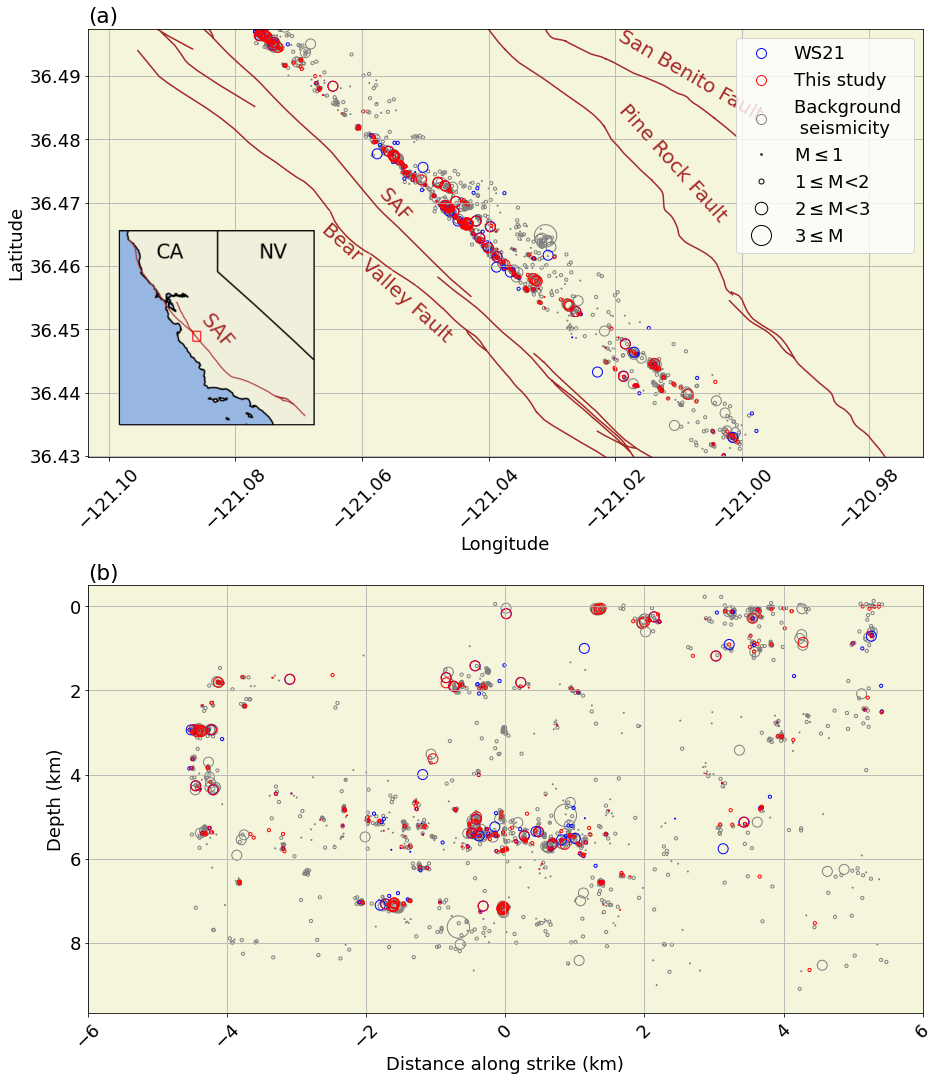

In [38]:
plt.rcParams.update({'font.size': 22})

## Figure specs 
width_s = 3.74016
height_s = 4.52756

width_m = width_s * 2
height_m = height_s * 2

width_l = width_s * 4
height_l = height_s * 4



plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(width_l,height_l), constrained_layout=True)

gs = gridspec.GridSpec(2, 1, wspace=0.5, hspace=0.3) # 2x2 grid


ax1 = fig.add_subplot(gs[0]) # map
ax2 = fig.add_subplot(gs[1]) # depth

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------

#Lower-left corner of inset Axes, and its width and height.

axins = ax1.inset_axes([-.15, 0., 0.6, 0.6])
inset = plt.imread('../reports/figures/insetMap.png')
axins.imshow(inset,path_effects=path_effects.SimplePatchShadow())
axins.patch.set_facecolor('beige')
axins.axis('off')

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------


legend_elements1 = [
                   Line2D([0], [0], marker='o', color='b', label=f'WS21',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='r', label=f'This study',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='grey', label=f'Background \n seismicity',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='.', color='k', label=r'M$\leq$1',markerfacecolor='none', markersize=3,lw=0),                                      
                   Line2D([0], [0], marker='.', color='k', label=r'1$\leq$M<2',markerfacecolor='none', markersize=100*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='2$\leq$M<3',markerfacecolor='none', markersize=250*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='3$\leq$M',markerfacecolor='none', markersize=400*.1,lw=0)]




ax1.legend(loc='upper right',handles=legend_elements1)#bbox_to_anchor=(0,1.4))

# ##----------------------------------------------------------------------
# ##### ##### ##### DEM ##### ##### ##### 
# data from HARP Digital Elevation Model Files: 
# https://ww2.arb.ca.gov/resources/documents/harp-digital-elevation-model-files
# ##----------------------------------------------------------------------

dem_file = '/Users/theresasawi/Documents/11_Manuscripts/SA_REQS/data/creep/topo_valley/topo_valley_30m.dem'  
dem_file2 = '/Users/theresasawi/Documents/11_Manuscripts/SA_REQS/data/creep/rock_spring_peak/rock_spring_peak30m.dem'  

NORTH_LATITUDE= 36.500000
SOUTH_LATITUDE= 36.375000
WEST_LONGITUDE= -121.125000
EAST_LONGITUDE= -121.000000

NORTH_LATITUDE2 = 36.500000
SOUTH_LATITUDE2 = 36.375000
WEST_LONGITUDE2 = -121.000000
EAST_LONGITUDE2 = -120.875000
    
buff = 0.0001
cat_lat = min(cat_all.lat)-buff,max(cat_all.lat)+buff
cat_lon = min(cat_all.long)-buff,max(cat_all.long)+buff



with rasterio.open(dem_file) as src:
    # Read the elevation data
    elevation = src.read(1)  # Assumes the elevation data is in the first band (band index 1)

    # Get the transformation matrix to convert pixel coordinates to lon/lat
#     transform = src.transform
    
with rasterio.open(dem_file2) as src:
    # Read the elevation data
    elevation2 = src.read(1)  # Assumes the elevation data is in the first band (band index 1)



##----------------------------------------------------------------------
##### ##### ##### Plot Faults ##### ##### ##### 
##----------------------------------------------------------------------


fault_df = pd.read_csv('../data/creep/felix_CA_Qfaults.csv',header=None,delim_whitespace=True,names=['lat','lon','ID'])
ax1.plot(fault_df.lon,fault_df.lat,color='brown')
# ax1.text(-121.0566,36.465,'SAF',rotation=-48,fontsize=30, color='brown')




##----------------------------------------------------------------------
##### ##### ##### NEW Map view  / depth ##### ##### ##### 
##----------------------------------------------------------------------



plotScatterMapRID(cat_all_plusBG,plotNew=1,ax=ax1)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')


lat0,lon0 = np.mean(cat2_stats.lat),-121.04#np.mean(cat2_stats.long)


# plt.scatter(cat_NCADD_trim.dist_along_strike_km,cat_NCADD_trim.DEP)
plotScatterMapDepthAlongStrikeRID(cat_all_plusBG,lat0,lon0,angle=48+90,plotNew=1,ax=ax2)


ax2.set_xlabel('Distance along strike (km)')
ax2.set_ylabel('Depth (km)')
ax2.tick_params(axis='x', labelrotation=45)

ax1.set_title('(a)',loc='left')
ax2.set_title('(b)',loc='left')

ax1.patch.set_facecolor('beige')
ax2.patch.set_facecolor('beige')

ax1.axis('equal')
# ax2.axis('equal')

ax2.set_ylim(ymax=-.5)
ax2.set_xlim(-6,6)
# ax1.set_xlim((minlon),(maxlon))
# ax1.set_ylim((minlat),(maxlat))

buff = .0
ax1.set_xlim(min(cat_lon)-buff,max(cat_lon)+buff)
ax1.set_ylim(min(cat_lat)-buff,max(cat_lat)+buff)


ax1.text(-121.058,36.467,'SAF',rotation=-48,fontsize=20, color='brown')
ax1.text(-121.067,36.448,'Bear Valley Fault',rotation=-42,fontsize=20, color='brown')
ax1.text(-121.02,36.483,'San Benito Fault',rotation=-30,fontsize=20, color='brown')
ax1.text(-121.02,36.467,'Pine Rock Fault',rotation=-48,fontsize=20, color='brown')

# ax2.invert_yaxis()
plt.savefig('../reports/figures/Figure_1_updated_v4_slide.png')


# Edit figure 1

cat_new_raw 1286
cat_new_raw 287
cat_new 287


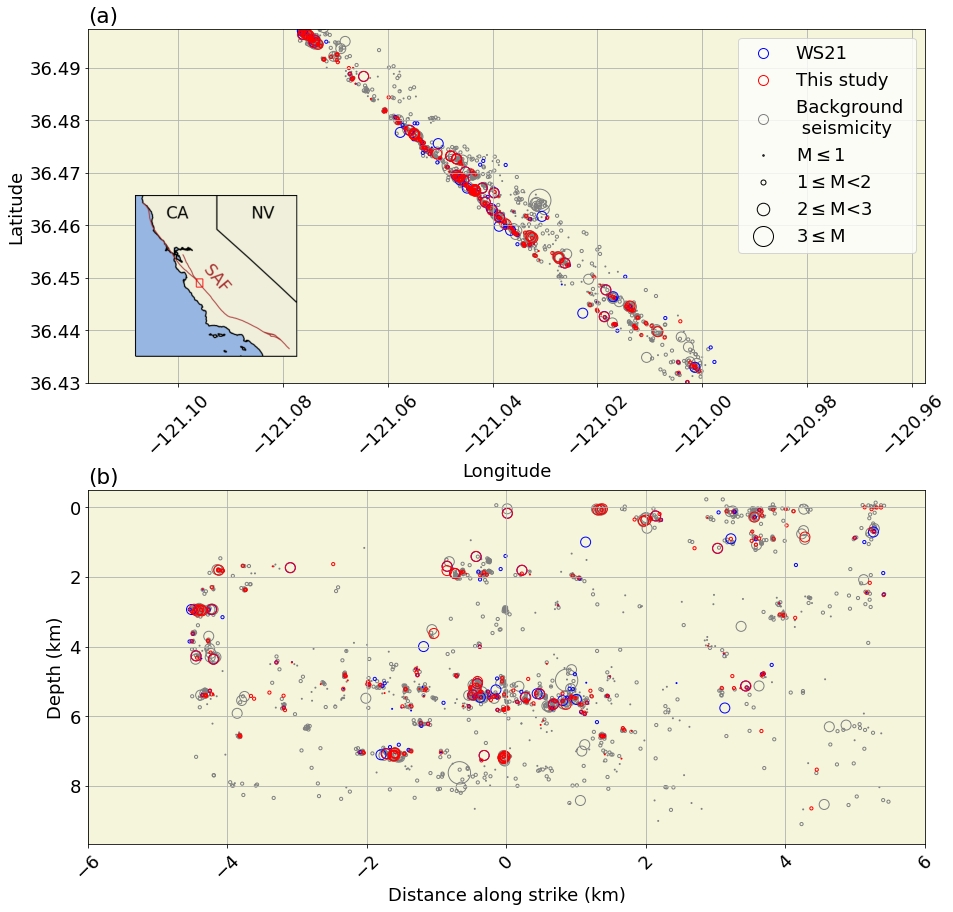

In [39]:
plt.rcParams.update({'font.size': 18})


## Figure specs 
width_s = 3.74016
height_s = 4.52756

width_m = width_s * 2
height_m = height_s * 2

width_l = width_s * 4
height_l = height_s * 4



plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(15,15), constrained_layout=True)

gs = gridspec.GridSpec(2, 1, wspace=0.5, hspace=0.3) # 2x2 grid


ax1 = fig.add_subplot(gs[0]) # map
ax2 = fig.add_subplot(gs[1]) # depth

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------

#Lower-left corner of inset Axes, and its width and height.

axins = ax1.inset_axes([-.15, 0., 0.6, 0.6])
inset = plt.imread('../reports/figures/insetMap.png')
axins.imshow(inset,path_effects=path_effects.SimplePatchShadow())
axins.patch.set_facecolor('beige')
axins.axis('off')

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------


legend_elements1 = [
                   Line2D([0], [0], marker='o', color='b', label=f'WS21',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='r', label=f'This study',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='grey', label=f'Background \n seismicity',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='.', color='k', label=r'M$\leq$1',markerfacecolor='none', markersize=3,lw=0),                                      
                   Line2D([0], [0], marker='.', color='k', label=r'1$\leq$M<2',markerfacecolor='none', markersize=100*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='2$\leq$M<3',markerfacecolor='none', markersize=250*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='3$\leq$M',markerfacecolor='none', markersize=400*.1,lw=0)]




ax1.legend(loc='upper right',handles=legend_elements1)#bbox_to_anchor=(0,1.4))

# ##----------------------------------------------------------------------
# ##### ##### ##### DEM ##### ##### ##### 
# data from HARP Digital Elevation Model Files: 
# https://ww2.arb.ca.gov/resources/documents/harp-digital-elevation-model-files
# ##----------------------------------------------------------------------

dem_file = '/Users/theresasawi/Documents/11_Manuscripts/SA_REQS/data/creep/topo_valley/topo_valley_30m.dem'  
dem_file2 = '/Users/theresasawi/Documents/11_Manuscripts/SA_REQS/data/creep/rock_spring_peak/rock_spring_peak30m.dem'  

NORTH_LATITUDE= 36.500000
SOUTH_LATITUDE= 36.375000
WEST_LONGITUDE= -121.125000
EAST_LONGITUDE= -121.000000

NORTH_LATITUDE2 = 36.500000
SOUTH_LATITUDE2 = 36.375000
WEST_LONGITUDE2 = -121.000000
EAST_LONGITUDE2 = -120.875000
    
buff = 0.0001
cat_lat = min(cat_all.lat)-buff,max(cat_all.lat)+buff
cat_lon = min(cat_all.long)-buff,max(cat_all.long)+buff



with rasterio.open(dem_file) as src:
    # Read the elevation data
    elevation = src.read(1)  # Assumes the elevation data is in the first band (band index 1)

    # Get the transformation matrix to convert pixel coordinates to lon/lat
#     transform = src.transform
    
with rasterio.open(dem_file2) as src:
    # Read the elevation data
    elevation2 = src.read(1)  # Assumes the elevation data is in the first band (band index 1)



##----------------------------------------------------------------------
##### ##### ##### Plot Faults ##### ##### ##### 
##----------------------------------------------------------------------


# fault_df = pd.read_csv('../data/creep/felix_CA_Qfaults.csv',header=None,delim_whitespace=True,names=['lat','lon','ID'])
# ax1.plot(fault_df.lon,fault_df.lat,color='brown')
# # ax1.text(-121.0566,36.465,'SAF',rotation=-48,fontsize=30, color='brown')




##----------------------------------------------------------------------
##### ##### ##### NEW Map view  / depth ##### ##### ##### 
##----------------------------------------------------------------------



plotScatterMapRID(cat_all_plusBG,plotNew=1,ax=ax1)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')


lat0,lon0 = np.mean(cat2_stats.lat),-121.04#np.mean(cat2_stats.long)


# plt.scatter(cat_NCADD_trim.dist_along_strike_km,cat_NCADD_trim.DEP)
plotScatterMapDepthAlongStrikeRID(cat_all_plusBG,lat0,lon0,angle=48+90,plotNew=1,ax=ax2)


ax2.set_xlabel('Distance along strike (km)')
ax2.set_ylabel('Depth (km)')
ax2.tick_params(axis='x', labelrotation=45)

ax1.set_title('(a)',loc='left')
ax2.set_title('(b)',loc='left')

ax1.patch.set_facecolor('beige')
ax2.patch.set_facecolor('beige')

ax1.axis('equal')
# ax2.axis('equal')

ax2.set_ylim(ymax=-.5)
ax2.set_xlim(-6,6)
# ax1.set_xlim((minlon),(maxlon))
# ax1.set_ylim((minlat),(maxlat))

buff = .0
ax1.set_xlim(min(cat_lon)-buff,max(cat_lon)+buff)
ax1.set_ylim(min(cat_lat)-buff,max(cat_lat)+buff)


# ax1.text(-121.058,36.467,'SAF',rotation=-48,fontsize=20, color='brown')
# ax1.text(-121.067,36.448,'Bear Valley Fault',rotation=-42,fontsize=20, color='brown')
# ax1.text(-121.02,36.483,'San Benito Fault',rotation=-30,fontsize=20, color='brown')
# ax1.text(-121.02,36.467,'Pine Rock Fault',rotation=-48,fontsize=20, color='brown')

# ax2.invert_yaxis()
plt.savefig('../reports/figures/Figure_1_updated_v4_slide.png')


# Figure 1, with off- fault BG seismicity

In [40]:
cat_NCADD_5km_2019 = pd.read_csv('../data/catalogs/NCADDiff_5km_2019.csv')

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
from math import radians, tan

def plot_line(lat, lon, angle_deg,ls='--',ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    # Convert angle to radians
    angle_rad = radians(angle_deg)

    # Calculate line endpoints
    line_length = 0.1  # Example line length in degrees
    line_lat = [lat - line_length / 2 * tan(angle_rad), lat + line_length / 2 * tan(angle_rad)]
    line_lon = [lon - line_length / 2, lon + line_length / 2]

    # Create a figure and axis

    # Plot the line
    ax.plot(line_lon, line_lat, color='k', label='Line', ls= ls)

    # Set aspect ratio and labels
    ax.set_aspect('equal', adjustable='datalim')

    


def distKmtoLatLon(start_latitude = 36.465,start_longitude = -121.037,delta_distance = 0.5,angle_deg = 138.0):
# Starting point



    # Change in latitude (in radians)
      # km
    earth_radius = 6371  # km
    delta_latitude_rad = delta_distance / earth_radius
    angle_deg = 360 -  angle_deg 
    # Convert angle to counterclockwise from eastward direction
    

    # Calculate change in longitude (in radians)
    delta_longitude_rad = delta_distance / (earth_radius * math.cos(math.radians(start_latitude)))

    # Convert radians to degrees
    delta_latitude_deg = math.degrees(delta_latitude_rad)
    delta_longitude_deg = math.degrees(delta_longitude_rad)

    # Calculate new coordinates
    new_latitude = start_latitude + delta_latitude_deg
    new_longitude = start_longitude + delta_longitude_deg

    return new_latitude, new_longitude

new_latitude, new_longitude = distKmtoLatLon()


cat_new_raw 1286
cat_new_raw 287
cat_new 287


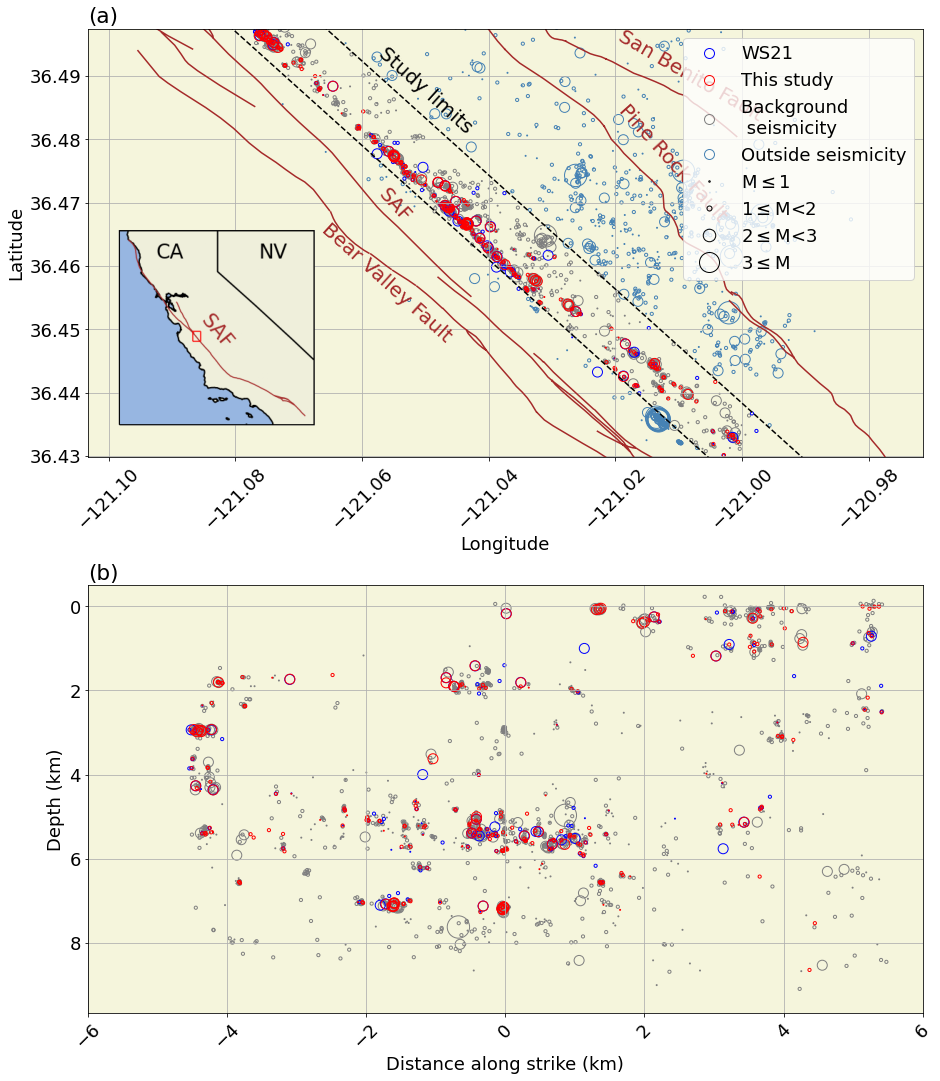

In [42]:
## Figure specs 
width_s = 3.74016
height_s = 4.52756

width_m = width_s * 2
height_m = height_s * 2

width_l = width_s * 4
height_l = height_s * 4



plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(width_l,height_l), constrained_layout=True)

gs = gridspec.GridSpec(2, 1, wspace=0.5, hspace=0.3) # 2x2 grid


ax1 = fig.add_subplot(gs[0]) # map
ax2 = fig.add_subplot(gs[1]) # depth

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------

#Lower-left corner of inset Axes, and its width and height.

axins = ax1.inset_axes([-.15, 0., 0.6, 0.6])
inset = plt.imread('../reports/figures/insetMap.png')
axins.imshow(inset,path_effects=path_effects.SimplePatchShadow())
axins.patch.set_facecolor('beige')
axins.axis('off')

##----------------------------------------------------------------------
##### ##### ##### INSET ##### ##### ##### 
##----------------------------------------------------------------------


legend_elements1 = [
                   Line2D([0], [0], marker='o', color='b', label=f'WS21',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='r', label=f'This study',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='grey', label=f'Background \n seismicity',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='steelblue', label=f'Outside seismicity',markerfacecolor='none', markersize=10,lw=0),
                   Line2D([0], [0], marker='.', color='k', label=r'M$\leq$1',markerfacecolor='none', markersize=3,lw=0),                                      
                   Line2D([0], [0], marker='.', color='k', label=r'1$\leq$M<2',markerfacecolor='none', markersize=100*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='2$\leq$M<3',markerfacecolor='none', markersize=250*.1,lw=0),
                   Line2D([0], [0], marker='.', color='k', label='3$\leq$M',markerfacecolor='none', markersize=400*.1,lw=0)]




ax1.legend(loc='upper right',handles=legend_elements1)#bbox_to_anchor=(0,1.4))


buff = 0.0001
cat_lat = min(cat_all.lat)-buff,max(cat_all.lat)+buff
cat_lon = min(cat_all.long)-buff,max(cat_all.long)+buff


##----------------------------------------------------------------------
##### ##### ##### Plot Faults ##### ##### ##### 
##----------------------------------------------------------------------


fault_df = pd.read_csv('../data/creep/felix_CA_Qfaults.csv',header=None,delim_whitespace=True,names=['lat','lon','ID'])
ax1.plot(fault_df.lon,fault_df.lat,color='brown')
# ax1.text(-121.0566,36.465,'SAF',rotation=-48,fontsize=30, color='brown')




#####################################################################################
#####  Off fault seismicity
#####################################################################################

cat_NCADD_5km_2019_0 = cat_NCADD_5km_2019[~cat_NCADD_5km_2019.event_ID.isin(list(cat_all_plusBG.event_ID))]

# ax1.scatter(cat_NCADD_5km_2019_0.long,cat_NCADD_5km_2019_0.lat,s=1)
cat_NCADD_5km_2019_0['RID'] = 9999
cat_NCADD_5km_2019_0['RID2'] = 9999

plotScatterMapRID_basic(cat_NCADD_5km_2019_0,ax=ax1)

lat0, lon0 = 36.465,-121.037

#trim large catalog
fault_buff = .5


delta_distance = .35
new_latitude, new_longitude = distKmtoLatLon(lat0, lon0, delta_distance , 48 + 180)
new_latitude2, new_longitude2 = distKmtoLatLon(lat0, lon0, -delta_distance , 48 + 180)


# plot_line(lat0, lon0, 48+90,ax=ax1,ls='-')
plot_line(new_latitude, new_longitude, 48+90,ax=ax1,ls='--')
plot_line(new_latitude2, new_longitude2, 48+90,ax=ax1,ls='--')


#####################################################################################


plotScatterMapRID(cat_all_plusBG,plotNew=1,ax=ax1)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')


lat0,lon0 = np.mean(cat2_stats.lat),-121.04#np.mean(cat2_stats.long)


# plt.scatter(cat_NCADD_trim.dist_along_strike_km,cat_NCADD_trim.depth_km)
plotScatterMapDepthAlongStrikeRID(cat_all_plusBG,lat0,lon0,angle=48+90,plotNew=1,ax=ax2)






ax2.set_xlabel('Distance along strike (km)')
ax2.set_ylabel('Depth (km)')
ax2.tick_params(axis='x', labelrotation=45)

ax1.set_title('(a)',loc='left')
ax2.set_title('(b)',loc='left')

ax1.patch.set_facecolor('beige')
ax2.patch.set_facecolor('beige')

ax1.axis('equal')
# ax2.axis('equal')

ax2.set_ylim(ymax=-.5)
ax2.set_xlim(-6,6)

buff = .0
ax1.set_xlim(min(cat_lon)-buff,max(cat_lon)+buff)
ax1.set_ylim(min(cat_lat)-buff,max(cat_lat)+buff)


ax1.text(-121.058,36.467,'SAF',rotation=-48,fontsize=20, color='brown')
ax1.text(-121.067,36.448,'Bear Valley Fault',rotation=-42,fontsize=20, color='brown')
ax1.text(-121.02,36.483,'San Benito Fault',rotation=-30,fontsize=20, color='brown')
ax1.text(-121.02,36.467,'Pine Rock Fault',rotation=-48,fontsize=20, color='brown')

ax1.text(-121.058,36.481,'Study limits',rotation=-42,fontsize=20, color='k')

# ax2.invert_yaxis()
plt.savefig('../reports/figures/Figure_1_updated_v5_slide.png')


# Figure 3

In [43]:
## paths and parameters
from matplotlib.gridspec import GridSpec

lenData=1000
trimLead=0
tmin=4
tmax=14
fmin=2
fmax=17
station ='BAV'

station_list = ['BAV','BPI','BRV','BBN','BSG','BEM','BVL']
channel='EHZ'
fs=100

dataH5_path = '../data/H5files/data_SA_REQS_v28.h5'
dataH5_path_list =   ['../data/H5files/data_SA_REQS_v28.h5',
                       '../data/H5files/data_SA_REQS_v28_BPI.h5',
                       '../data/H5files/data_SA_REQS_v28_BRV.h5',
                       '../data/H5files/data_SA_REQS_v28_BBN.h5',
                       '../data/H5files/data_SA_REQS_v28_BSG.h5',
                       '../data/H5files/data_SA_REQS_v28_BEM.h5',
                       '../data/H5files/data_SA_REQS_v28_BVL.h5']  


SpecUFEx_H5_path_list = ['../data/H5files/SpecUFEx_SA_REQS_v28.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BPI.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BRV.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BBN.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BSG.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BEM.h5',
             '../data/H5files/SpecUFEx_SA_REQS_v28_BVL.h5']  


## Figure specs 
width_s = 3.74016
height_s = 4.52756

width_m = width_s * 2
height_m = height_s * 2

width_l = width_s * 4
height_l = height_s * 4

SS2003 = pd.Timestamp(2003,12,22,0,0,0)
MH1984 = pd.Timestamp(1984,4,24,0,0,0)
PF2004 = pd.Timestamp(2004,9,28,0,0,0)
LP = pd.Timestamp(1989,10,17,0,0,0)

SA2014 = pd.Timestamp(2014,8,24,0,0,0)
SA1991 = pd.Timestamp(1991,8,17,0,0,0)#M7
SA1992 = pd.Timestamp(1992,4,25,0,0,0)#M7
SA1994 = pd.Timestamp(1994,9,1,0,0,0)#M7
SA2013 = pd.Timestamp(2013,5,24,0,0,0)
SA2016 = pd.Timestamp(2016,8,10,0,0,0)



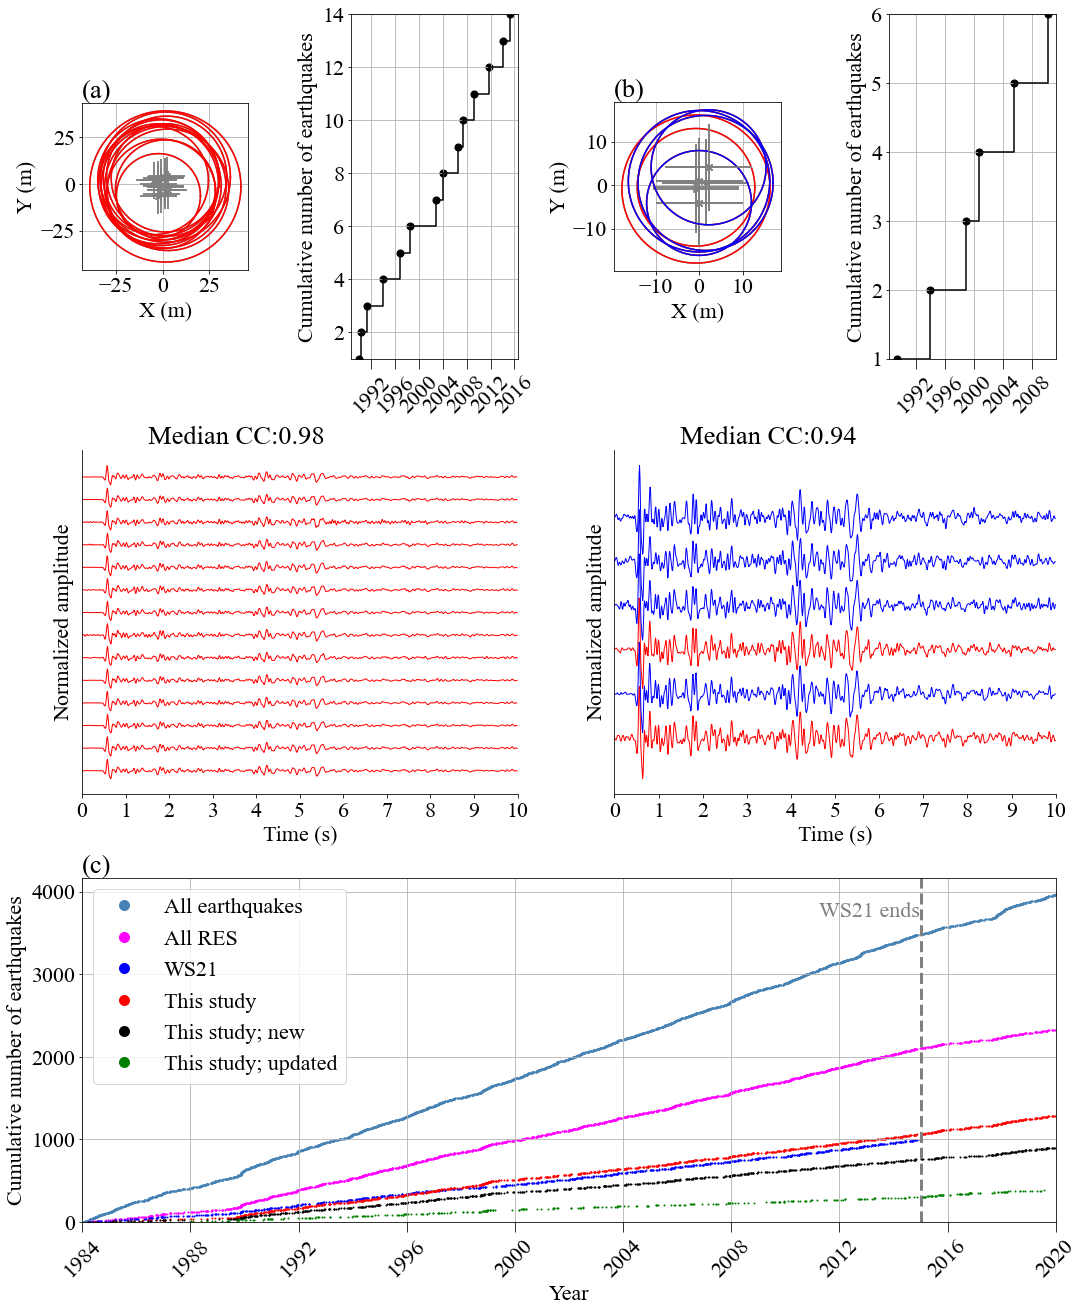

In [44]:
updated_df = cat_all[cat_all.isUpdated==1]
new_df = cat_all[cat_all.isAllNew==1]
old_df = cat_all[cat_all.isAllNew==0]

cat_thisStudy = pd.concat([new_df,updated_df[updated_df.RID=='0']])


# Set the font family to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 22})


# cluster_examp = [22.0, 100.0]
cluster_examp = ['Rx.10044', 'R0.0205.10327.0.u']
# cluster_examp = [2, 376]


fig = plt.figure(constrained_layout=True,figsize=(width_l,height_l))
# plt.subplots_adjust(hspace=.5)

gs = GridSpec(3, 4, figure=fig)


ax = fig.add_subplot(gs[2:,:])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1:2,0:2])

ax4 = fig.add_subplot(gs[0,2])
ax5 = fig.add_subplot(gs[0,3])
ax6 = fig.add_subplot(gs[1:2,2:])


ax.set_title('(c)',loc='left')
ax1.set_title('(a)',loc='left')
# ax2.set_title('(c)',loc='left')
# ax3.set_title('(d)',loc='left')
ax4.set_title('(b)',loc='left')
# ax5.set_title('(f)',loc='left')
# ax6.set_title('(g)',loc='left')



slope, r, dates  = plotCumul3(cat_NCSN,color1='steelblue',color2='steelblue',ax=ax);
# ax.text(dates[-1],len(cat_NCSN),s=f"({slope:.0f})",rotation=0,color='steelblue')

slope, r, dates  = plotCumul3(cat_all,color1='fuchsia',color2='fuchsia',ax=ax);
# ax.text(dates[-1],len(cat_all),s=f"({slope:.0f})",rotation=0,color='fuchsia')

slope, r, dates  = plotCumul3(cat_WS21_reloc,color1='b',color2='b',ax=ax);
# ax.text(dates[-1],len(cat_WS21_reloc)-200,s=f"({slope:.0f})",rotation=0,color='k')

# slope, r, dates  = plotCumul3(cat_comb_recovered,color1='grey',color2='grey',ax=ax);
# ax.text(dates[-1],len(cat_comb_recovered)+30,s=f"({slope:.0f})",rotation=0,color='k')


slope, r, dates  = plotCumul3(cat_thisStudy,color1='r',color2='r',ax=ax);
# ax.text(dates[-1],len(cat_thisStudy)+30,s=f"({slope:.0f})",rotation=0,color='r')

slope, r, dates  = plotCumul3(new_df,color1='k',color2='k',ax=ax);
# ax.text(dates[-1],len(new_df),s=f"({slope:.0f})",rotation=0,color='b')

slope, r, dates  = plotCumul3(updated_df[updated_df.RID=='0'],color1='g',color2='g',ax=ax);
# ax.text(dates[-1],len(updated_df[updated_df.RID=='0']),s=f"({slope:.0f})",rotation=0,color='g')

# ax.set_ylabel('Cumulative number of repeating earthquakes')
ax.set_xlabel('Year')
ax.axvline(pd.Timestamp(2015,1,1),color='grey',lw=3,ls='--')

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation = 45)
# ax.yaxis.set_label_position("left")
# ax.yaxis.tick_left()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

# ax.set_ylim(0,3000)

# axtwin = ax.twinx()
# # plotCumulMoment(cat_comb_stats,ax=axtwin)
# # plotCumulMoment(cat_NCSN,color1='steelblue',color2='skyblue',ax=axtwin)
# # axtwin.set_ylim(0,5e22)
# axtwin.grid('off')
# axtwin.grid('off')



legend_elements = [
                   Line2D([0], [0], marker='o', color='steelblue', label=f'All earthquakes',markerfacecolor='steelblue', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='fuchsia', label=f'All RES',markerfacecolor='fuchsia', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='b', label=f'WS21',markerfacecolor='b', markersize=10,lw=0),
#                    Line2D([0], [0], marker='o', color='k', label=f'Recovered',markerfacecolor='k', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='r', label=f'This study',markerfacecolor='r', markersize=10,lw=0),    
                   Line2D([0], [0], marker='o', color='k', label=f'This study; new',markerfacecolor='k', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='g', label=f'This study; updated',markerfacecolor='g', markersize=10,lw=0)] 
#                    Line2D([0], [0], marker='o', color='darkorange', label=f'Moment',markerfacecolor='darkorange', markersize=10,lw=0)]

ax.legend(handles=legend_elements,loc='upper left')#,bbox_to_anchor=(1.59,1))



###---------------------------------------------------------------------------------------------------------------

###---------------------------------------------------------------------------------------------------------------

df_cl = cat_all[cat_all.RID2==cluster_examp[0]]
df_cl.event_ID = df_cl.event_ID.astype('int')
# grade = df_cl.Grade.iloc[0]
df_cl.sort_index(inplace=True)
ccmat2, lag_mat = calcCCMatrix(df_cl,
                            lenData,
                            dataH5_path,
                            'BAV',
                            channel,
                            fmin,
                            fmax,
                            tmin,tmax,
                            fs) 

medCC2 = np.median(upper_tri_masking(ccmat2))

plotLocZoomMeters(df_cl,df_cl,fontsize=12,ax=ax1)

plotCumul5(df_cl,ax=ax2)  
ax2.set_ylim(1,len(df_cl)) 
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='x', labelrotation=45)

plotClusWF6(df_cl,df_cl,lag_mat,0,'k',
            dataH5_path,station,channel,
            fmin,fmax,tmin,tmax,fs,alpha=1,
            fontsize=10,offset=True,ax=ax3)
# ax3.set_title(f'          {station}-{channel}, median CC:{medCC2:.2f}',loc='left') 
ax3.set_title(f'          Median CC:{medCC2:.2f}',loc='left') 

###---------------------------------------------------------------------------------------------------------------

###---------------------------------------------------------------------------------------------------------------

df_cl2 = cat_all[cat_all.RID2==cluster_examp[1]]
df_cl2.event_ID = df_cl2.event_ID.astype('int')
# grade = df_cl2.Grade.iloc[0]
df_cl2.sort_index(inplace=True)
ccmat1, lag_mat = calcCCMatrix(df_cl2,
                            lenData,
                            dataH5_path,
                            'BAV',
                            channel,
                            fmin,
                            fmax,
                            tmin,tmax,
                            fs
                             ) 

medCC1 = np.median(upper_tri_masking(ccmat1))

plotLocZoomMeters(df_cl2,df_cl2,fontsize=12,ax=ax4)

plotCumul5(df_cl2,ax=ax5)  
ax5.set_ylim(1,len(df_cl2)) 
# ax5.spines['top'].set_visible(False)
# ax5.spines['right'].set_visible(False)
ax5.tick_params(axis='x', labelrotation=45)

plotClusWF6(df_cl2,df_cl2,lag_mat,0,'k',
            dataH5_path,station,channel,
            fmin,fmax,tmin,tmax,fs,alpha=1,
            fontsize=10,offset=True,ax=ax6)
# ax6.set_title(f'          {station}-{channel}, median CC:{medCC1:.2f}',loc='left') 
ax6.set_title(f'          Median CC:{medCC1:.2f}',loc='left') 

ax5.set_title('')
ax2.set_title('')  

ax5.set_ylabel('Cumulative number of earthquakes')
ax2.set_ylabel('Cumulative number of earthquakes')  
ax.set_ylabel('Cumulative number of earthquakes')  

# ax1.set_title(f'{(cluster_examp[0])}')   
# ax4.set_title(f'{(cluster_examp[1])}')

ax.set_xlim(xmin=pd.Timestamp('1984-1-1'))
ax.set_xlim(xmax=pd.Timestamp('2020-1-1'))
ax.set_ylim(ymin=0)

ax3.set_xlim(0,1000)
ax6.set_xlim(0,1000)

ax.text(pd.Timestamp(2011,4,1),3700,'WS21 ends',color='grey')

plt.savefig('../reports/figures/Figure_3_cumul_updated_v2_slide.png', bbox_inches="tight")

# Break up figure 3

In [45]:
updated_df = cat_all[cat_all.isUpdated==1]
new_df = cat_all[cat_all.isAllNew==1]
old_df = cat_all[cat_all.isAllNew==0]

cat_thisStudy = pd.concat([new_df,updated_df[updated_df.RID=='0']])


# Set the font family to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 22})


Text(2010-01-01 00:00:00, 3700, 'WS21 ends')

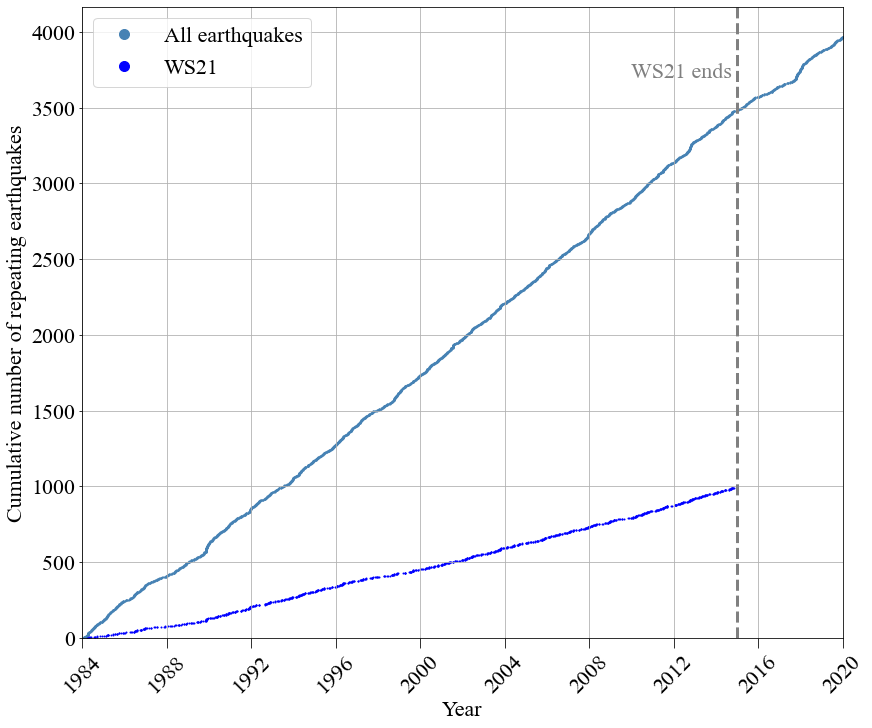

In [46]:


fig = plt.figure(constrained_layout=True,figsize=(12,10))
# plt.subplots_adjust(hspace=.5)

gs = GridSpec(1, 1, figure=fig)


ax = fig.add_subplot(gs[:])



slope, r, dates  = plotCumul3(cat_NCSN,color1='steelblue',color2='steelblue',ax=ax);
# ax.text(dates[-1],len(cat_NCSN),s=f"({slope:.0f})",rotation=0,color='steelblue')

# slope, r, dates  = plotCumul3(cat_all,color1='fuchsia',color2='fuchsia',ax=ax);
# # ax.text(dates[-1],len(cat_all),s=f"({slope:.0f})",rotation=0,color='fuchsia')

slope, r, dates  = plotCumul3(cat_WS21_reloc,color1='b',color2='b',ax=ax);
# ax.text(dates[-1],len(cat_WS21_reloc)-200,s=f"({slope:.0f})",rotation=0,color='k')


# slope, r, dates  = plotCumul3(cat_thisStudy,color1='r',color2='r',ax=ax);
# # ax.text(dates[-1],len(cat_thisStudy)+30,s=f"({slope:.0f})",rotation=0,color='r')

# slope, r, dates  = plotCumul3(new_df,color1='k',color2='k',ax=ax);
# # ax.text(dates[-1],len(new_df),s=f"({slope:.0f})",rotation=0,color='b')

# slope, r, dates  = plotCumul3(updated_df[updated_df.RID=='0'],color1='g',color2='g',ax=ax);
# # ax.text(dates[-1],len(updated_df[updated_df.RID=='0']),s=f"({slope:.0f})",rotation=0,color='g')

ax.set_ylabel('Cumulative number of repeating earthquakes')
ax.set_xlabel('Year')
ax.axvline(pd.Timestamp(2015,1,1),color='grey',lw=3,ls='--')

ax.tick_params(axis='x', labelrotation = 45)


legend_elements = [
                   Line2D([0], [0], marker='o', color='steelblue', label=f'All earthquakes',markerfacecolor='steelblue', markersize=10,lw=0),
#                    Line2D([0], [0], marker='o', color='fuchsia', label=f'All RES',markerfacecolor='fuchsia', markersize=10,lw=0),
                   Line2D([0], [0], marker='o', color='b', label=f'WS21',markerfacecolor='b', markersize=10,lw=0),
#                    Line2D([0], [0], marker='o', color='k', label=f'Recovered',markerfacecolor='k', markersize=10,lw=0),
#                    Line2D([0], [0], marker='o', color='r', label=f'This study',markerfacecolor='r', markersize=10,lw=0),    
#                    Line2D([0], [0], marker='o', color='k', label=f'This study; new',markerfacecolor='k', markersize=10,lw=0),
#                    Line2D([0], [0], marker='o', color='g', label=f'This study; updated',markerfacecolor='g', markersize=10,lw=0)] 
#                    Line2D([0], [0], marker='o', color='darkorange', label=f'Moment',markerfacecolor='darkorange', markersize=10,lw=0)]
]

ax.legend(handles=legend_elements,loc='upper left')#,bbox_to_anchor=(1.59,1))





ax.set_xlim(xmin=pd.Timestamp('1984-1-1'))
ax.set_xlim(xmax=pd.Timestamp('2020-1-1'))
ax.set_ylim(ymin=0)

ax.text(pd.Timestamp(2010,1,1),3700,'WS21 ends',color='grey')

# plt.savefig('../reports/figures/Figure_3_cumul_updated_v2_slide.png', bbox_inches="tight")

Text(0.0, 1.0, '          Median CC:0.98')

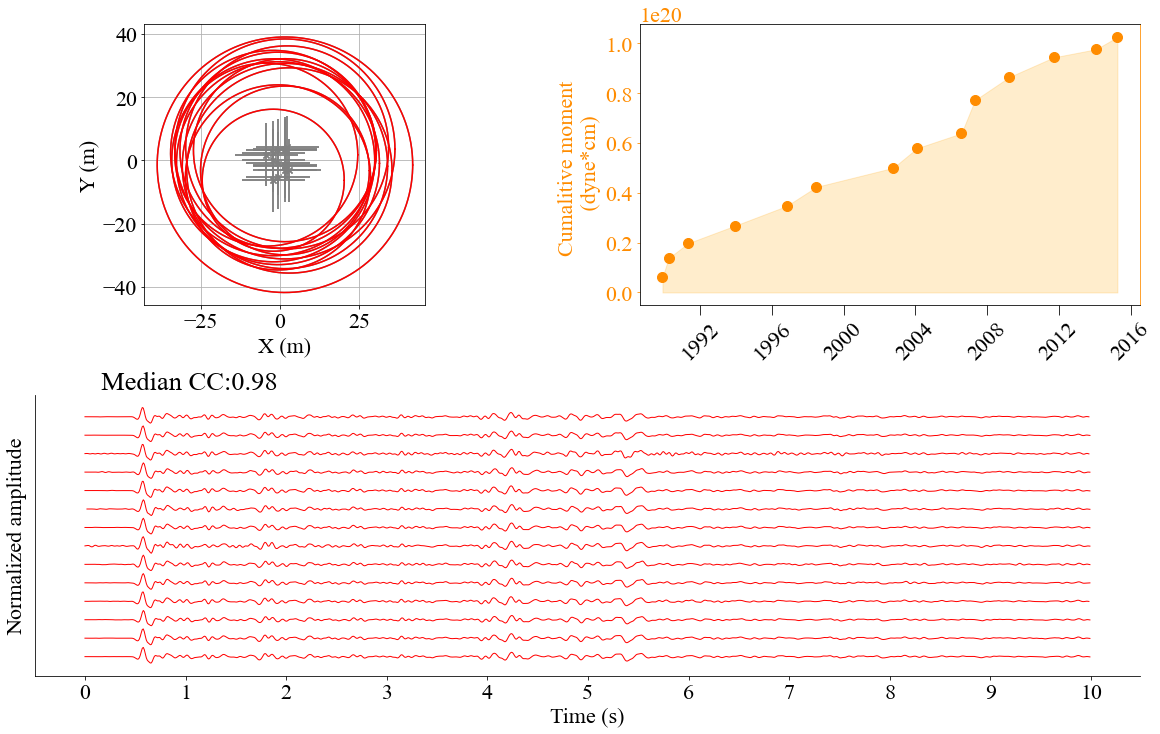

In [60]:

fig = plt.figure(constrained_layout=True,figsize=(16,14))
# plt.subplots_adjust(hspace=.5)

gs = GridSpec(3, 2, figure=fig)


ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1:2,:])


# cluster_examp = [22.0, 100.0]
cluster_examp = ['Rx.10044', 'R0.0205.10327.0.u']
# cluster_examp = [2, 376]


###---------------------------------------------------------------------------------------------------------------
### Waveform 1
###---------------------------------------------------------------------------------------------------------------

df_cl = cat_all[cat_all.RID2==cluster_examp[0]]
df_cl.event_ID = df_cl.event_ID.astype('int')
# grade = df_cl.Grade.iloc[0]
df_cl.sort_index(inplace=True)
ccmat2, lag_mat = calcCCMatrix(df_cl,
                            lenData,
                            dataH5_path,
                            'BAV',
                            channel,
                            fmin,
                            fmax,
                            tmin,tmax,
                            fs) 

medCC2 = np.median(upper_tri_masking(ccmat2))



plotLocZoomMeters(df_cl,df_cl,fontsize=12,ax=ax1)

df_cl['moment'] = [calcMom(m) for m in df_cl.magnitude]

plotCumulMoment(df_cl,color1='darkorange',color2='orange',ms=10,ax=ax2)

# plotCumul5(df_cl,ax=ax2)  
# ax2.set_ylim(1,len(df_cl)) 
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='x', labelrotation=45)

plotClusWF6(df_cl,df_cl,lag_mat,0,'k',
            dataH5_path,station,channel,
            fmin,fmax,tmin,tmax,fs,alpha=1,
            fontsize=10,offset=True,ax=ax3)
# ax3.set_title(f'          {station}-{channel}, median CC:{medCC2:.2f}',loc='left') 
ax3.set_title(f'          Median CC:{medCC2:.2f}',loc='left') 



Text(0.0, 1.0, '          Median CC:0.94')

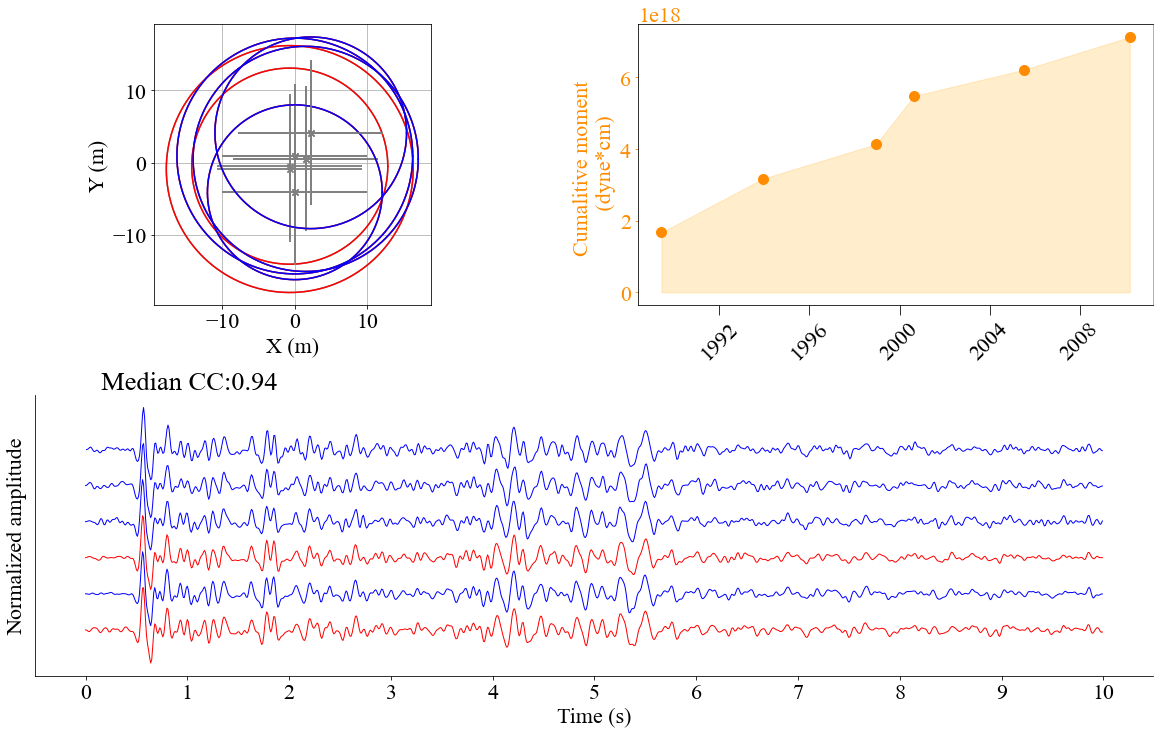

In [53]:
fig = plt.figure(constrained_layout=True,figsize=(16,14))
# plt.subplots_adjust(hspace=.5)

gs = GridSpec(3, 2, figure=fig)


ax4 = fig.add_subplot(gs[0,0])
ax5 = fig.add_subplot(gs[0,1])
ax6 = fig.add_subplot(gs[1:2,:])


df_cl2 = cat_all[cat_all.RID2==cluster_examp[1]]
df_cl2.event_ID = df_cl2.event_ID.astype('int')
# grade = df_cl2.Grade.iloc[0]
df_cl2.sort_index(inplace=True)
ccmat1, lag_mat = calcCCMatrix(df_cl2,
                            lenData,
                            dataH5_path,
                            'BAV',
                            channel,
                            fmin,
                            fmax,
                            tmin,tmax,
                            fs
                             ) 

medCC1 = np.median(upper_tri_masking(ccmat1))

plotLocZoomMeters(df_cl2,df_cl2,fontsize=12,ax=ax4)

df_cl2['moment'] = [calcMom(m) for m in df_cl2.magnitude]

plotCumulMoment(df_cl2,color1='darkorange',color2='orange',ms=10,ax=ax5)
# plotCumul5(df_cl2,ax=ax5)  
# ax5.set_ylim(1,len(df_cl2)) 
# ax5.spines['top'].set_visible(False)
# ax5.spines['right'].set_visible(False)
ax5.tick_params(axis='x', labelrotation=45)

plotClusWF6(df_cl2,df_cl2,lag_mat,0,'k',
            dataH5_path,station,channel,
            fmin,fmax,tmin,tmax,fs,alpha=1,
            fontsize=10,offset=True,ax=ax6)
# ax6.set_title(f'          {station}-{channel}, median CC:{medCC1:.2f}',loc='left') 
ax6.set_title(f'          Median CC:{medCC1:.2f}',loc='left')

27


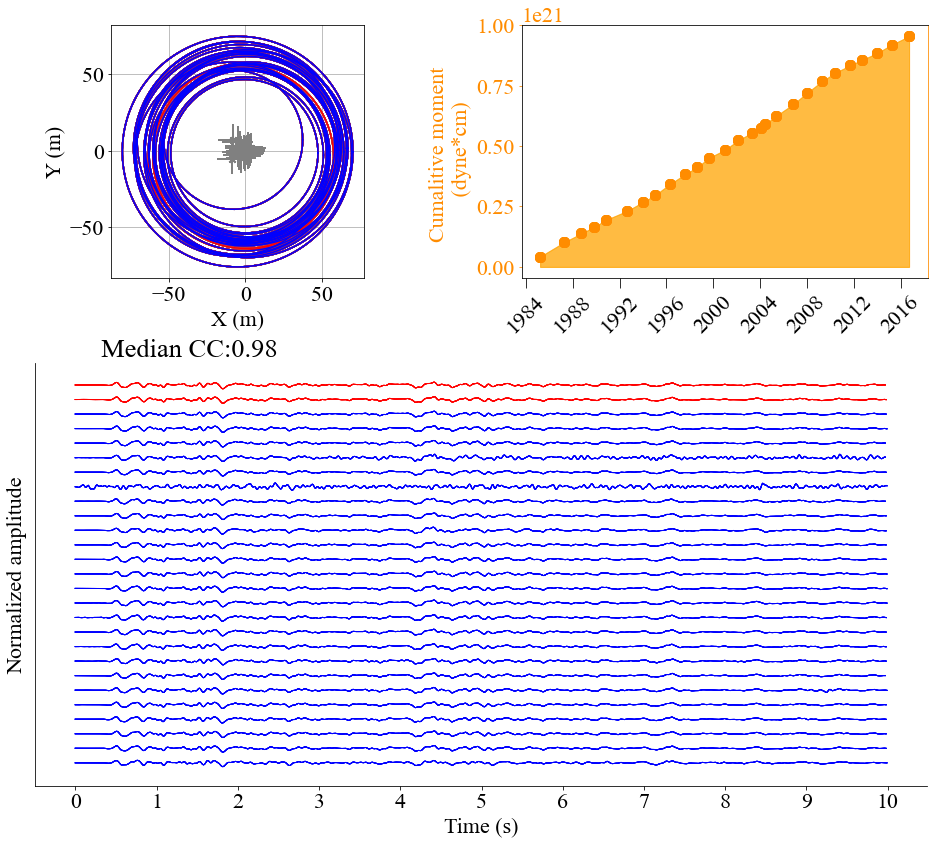

In [55]:
df_cl2 = cat_all[cat_all.RID2=='R2.0018.1204.1.C.u']
df_cl2['moment'] = [calcMom(m) for m in df_cl2.magnitude]




print(df_cl2.numEvents.iloc[0])
fig = plt.figure(constrained_layout=True,figsize=(16,14))
plt.subplots_adjust(hspace=1)

gs = GridSpec(5, 2, figure=fig)


ax4 = fig.add_subplot(gs[0:2,0])
ax5 = fig.add_subplot(gs[0:2,1])
ax6 = fig.add_subplot(gs[2:,:])


df_cl2.event_ID = df_cl2.event_ID.astype('int')
# grade = df_cl2.Grade.iloc[0]
df_cl2.sort_index(inplace=True)

for sta in station_list:
    try:
        ccmat1, lag_mat = calcCCMatrix(df_cl2,
                                    lenData,
                                    dataH5_path,
                                    sta,
                                    channel,
                                    fmin,
                                    fmax,
                                    tmin,tmax,
                                    fs
                                     ) 
    except:


        medCC1 = np.median(upper_tri_masking(ccmat1))

        plotLocZoomMeters(df_cl2,df_cl2,fontsize=12,ax=ax4)

        plotCumulMoment(df_cl2,color1='darkorange',color2='orange',ms=10,ax=ax5)
#         plotCumul5(df_cl2,ax=ax5)  
#         ax5.set_ylim(1,len(df_cl2)) 
        # ax5.spines['top'].set_visible(False)
        # ax5.spines['right'].set_visible(False)
        ax5.tick_params(axis='x', labelrotation=45)

        plotClusWF6(df_cl2,df_cl2,lag_mat,0,'k',
                    dataH5_path,station,channel,
                    fmin,fmax,tmin,tmax,fs,alpha=1,
                    fontsize=10,offset=True,ax=ax6)
        # ax6.set_title(f'          {station}-{channel}, median CC:{medCC1:.2f}',loc='left') 
        ax6.set_title(f'          Median CC:{medCC1:.2f}',loc='left')

Text(0.0, 1.0, '          Median CC:0.98')

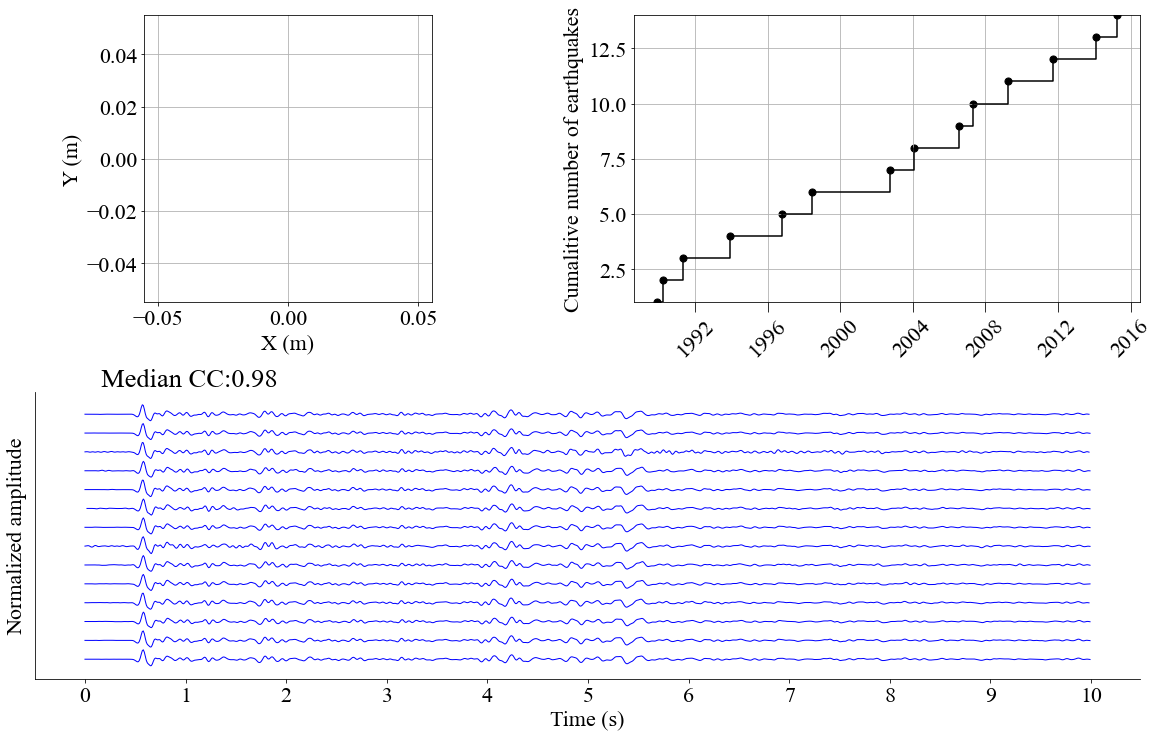

In [125]:
###---------------------------------------------------------------------------------------------------------------
### Waveform 2
###---------------------------------------------------------------------------------------------------------------

df_cl2 = cat_all[cat_all.RID==cluster_examp[1]]

fig = plt.figure(constrained_layout=True,figsize=(16,14))
# plt.subplots_adjust(hspace=.5)

gs = GridSpec(3, 2, figure=fig)


ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1:2,:])


# cluster_examp = [22.0, 100.0]
cluster_examp = ['Rx.10044', 'R0.0205.10327.0.u']
# cluster_examp = [2, 376]


###---------------------------------------------------------------------------------------------------------------
### Waveform 1
###---------------------------------------------------------------------------------------------------------------

df_cl2.event_ID = df_cl.event_ID.astype('int')
# grade = df_cl.Grade.iloc[0]
df_cl.sort_index(inplace=True)
ccmat2, lag_mat = calcCCMatrix(df_cl2,
                            lenData,
                            dataH5_path,
                            'BAV',
                            channel,
                            fmin,
                            fmax,
                            tmin,tmax,
                            fs) 

medCC2 = np.median(upper_tri_masking(ccmat2))



plotLocZoomMeters(df_cl2,df_cl2,fontsize=12,ax=ax1)

plotCumul5(df_cl2,ax=ax2)  
ax2.set_ylim(1,len(df_cl2)) 
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='x', labelrotation=45)

plotClusWF6(df_cl2,df_cl2,lag_mat,0,'k',
            dataH5_path,station,channel,
            fmin,fmax,tmin,tmax,fs,alpha=1,
            fontsize=10,offset=True,ax=ax3)
# ax3.set_title(f'          {station}-{channel}, median CC:{medCC2:.2f}',loc='left') 
ax3.set_title(f'          Median CC:{medCC2:.2f}',loc='left') 



# Figure 4

## Rolling avg binned by depth

In [89]:
cat1_stats_list = []

for cl in np.unique(cat1_stats_cont.RID):
    df_cl = cat1_stats_cont[cat1_stats_cont.RID==cl].copy()
    depth_mean = np.mean(df_cl.depth_km)
    df_cl['depth_mean'] = depth_mean
    cat1_stats_list.append(df_cl)
    
cat1_stats_depth = pd.concat(cat1_stats_list)
    
    
    
cat2_stats_list = []

for cl in np.unique(cat2_stats_cont.RID2):
    df_cl = cat2_stats_cont[cat2_stats_cont.RID2==cl].copy()
    depth_mean = np.mean(df_cl.depth_km)
    df_cl['depth_mean'] = depth_mean
    cat2_stats_list.append(df_cl)
    
cat2_stats_depth = pd.concat(cat2_stats_list)
    

In [91]:
len(cat2_stats_depth)

1388

# Map cat1 RESp using cat2 RESp locations


In [92]:
# Map cat1 RESp using cat2 RESp locations

## events in cat1 RESp that aren't in cat2 RESp
cat_solo1 = cat1_stats_depth[~cat1_stats_depth.event_ID.isin(cat2_stats_depth.event_ID.astype('str'))]

## events in cat2 RESp that are in cat1 RESp
cat_shared2 = cat2_stats_depth[cat2_stats_depth.event_ID.isin(cat1_stats_depth.event_ID.astype('int'))]


cat1_final = cat_solo1.append(cat_shared2)

# Get 500-m slip rate with depth

In [93]:
# & (cat2_stats_depth.CVr<.25)
cZ = cat2_stats_depth[cat2_stats_depth.numEvents>minNumEvents].drop_duplicates('RID2')
c1Z = cat1_stats_depth[cat1_stats_depth.numEvents>minNumEvents].drop_duplicates('RID')


In [94]:
len(cat2_stats_depth)

1388

In [95]:
######################################################################        
##### Get 500-m slip rate with depth #######        
######################################################################
####



### Radii

binSize = bin_size = .5
search_rad = .5
overlap=0
minNumEvents = 2


# Determine the range of the data
x_min, x_max = -5,6
y_min, y_max = 0,8



######################################################################        
##### Cat This study #######        
######################################################################

# & (cat2_stats_depth.CVr<.25)
cZ = cat2_stats_depth[cat2_stats_depth.numEvents>minNumEvents].drop_duplicates('RID2')
c1Z = cat1_stats_depth[cat1_stats_depth.numEvents>minNumEvents].drop_duplicates('RID')


# Compute the number of bins and overlap distance
num_bins_x = 1
num_bins_y = int((y_max - y_min) / (bin_size * (1 - overlap))) + 1


print(num_bins_x, 'by', num_bins_y, 'grid')


overlap_distance_x = bin_size * overlap
overlap_distance_y = bin_size * overlap




c_Z_med = []
c_Z_MAD = []

y_centers = []

for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.abs(cZ.depth_mean - y_center)
        
        # Select points within the search radius
        c_2 = cZ[distances < search_rad]
        
        c_Z_med.append(np.nanmedian(c_2.slipRate))
        c_Z_MAD.append(stats.median_abs_deviation(c_2.slipRate))

        y_centers.append(y_center)
            
c1_Z_med = []
c1_Z_MAD = []

for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.abs(c1Z.depth_mean - y_center)
        
        # Select points within the search radius
        c1_2 = c1Z[distances < search_rad]
        
        c1_Z_med.append(np.nanmedian(c1_2.slipRate))

        c1_Z_MAD.append(stats.median_abs_deviation(c1_2.slipRate))


1 by 17 grid


# Get 100-m slip rate along fault surface


In [96]:
### Radii

binSize = bin_size = .2
search_rad = .4
overlap = .5

minNumEvents = 2


# Determine the range of the data
x_min, x_max = -5,6
y_min, y_max = 0,8



######################################################################        
##### Cat This study #######        
######################################################################

# & (cat2_stats_depth.CVr<.25)
c = cat2_stats_depth[cat2_stats_depth.numEvents>minNumEvents].drop_duplicates('RID2')

x = c.dist_along_strike_km
y = c.depth_mean


# Compute the number of bins and overlap distance
num_bins_x = int((x_max - x_min) / (bin_size * (1 - overlap))) + 1
num_bins_y = int((y_max - y_min) / (bin_size * (1 - overlap))) + 1


print(num_bins_x, 'by', num_bins_y, 'grid')


overlap_distance_x = bin_size * overlap
overlap_distance_y = bin_size * overlap




c_tot_num = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c.dist_along_strike_km - x_center)**2 + (c.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c[distances < search_rad]
        
        if len(c_2) > 0:
            c_tot_num[j, i] = len(c_2)
        else:
            c_tot_num[j, i] = np.nan

            

            
c_tot = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c.dist_along_strike_km - x_center)**2 + (c.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c[distances < search_rad]
        
        c_tot[j, i] = np.nanmedian(c_2.slipRate)


c_tot_MAD = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c.dist_along_strike_km - x_center)**2 + (c.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c[distances < search_rad]
        
#         c_tot_MAD[j, i] = np.nanstd(c_2.slipRate)
        c_tot_MAD[j, i] = stats.median_abs_deviation(c_2.slipRate)  
        
        
        
######################################################################        
##### Cat WS21 #######        
######################################################################




# & (cat1_stats_depth.CVr<.25)
c1 = cat1_final[cat1_final.numEvents>minNumEvents].drop_duplicates('RID')
# c1 = cat1_stats_depth.drop_duplicates('RID')

c1_tot_num = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c1.dist_along_strike_km - x_center)**2 + (c1.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c1[distances < search_rad]
        
        if len(c_2) > 0:
            c1_tot_num[j, i] = len(c_2)
        else:
            c1_tot_num[j, i] = np.nan

            
c1_tot = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c1.dist_along_strike_km - x_center)**2 + (c1.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c1[distances < search_rad]
        
        c1_tot[j, i] = np.nanmedian(c_2.slipRate)

            

c1_tot_MAD = np.zeros([num_bins_y, num_bins_x])

for i in range(num_bins_x):
    x_center = x_min + (i * bin_size * (1 - overlap)) + (bin_size / 2)
    
    for j in range(num_bins_y):
        y_center = y_min + (j * bin_size * (1 - overlap)) + (bin_size / 2)
        
        # Calculate the Euclidean distance from the center point
        distances = np.sqrt((c1.dist_along_strike_km - x_center)**2 + (c1.depth_mean - y_center)**2)
        
        # Select points within the search radius
        c_2 = c1[distances < search_rad]
        
#         c1_tot_MAD[j, i] = np.nanstd(c_2.slipRate)
        c1_tot_MAD[j, i] = stats.median_abs_deviation(c_2.slipRate)        
        

    
            
            
            
print('done')

111 by 81 grid
done


# New arrangement

In [97]:
calcRadius(2)*4

210.5453199218792

In [98]:
# binSize = bin_size = .2
# search_rad = .4
# overlap = .5


# print(bin_size * (1 - overlap))
# print(np.diff(x_new)[0], np.diff(y_new)[0])

slipRate_depth_density_binsize0.2_searchRAD0.4_OL0.5_median_MAD


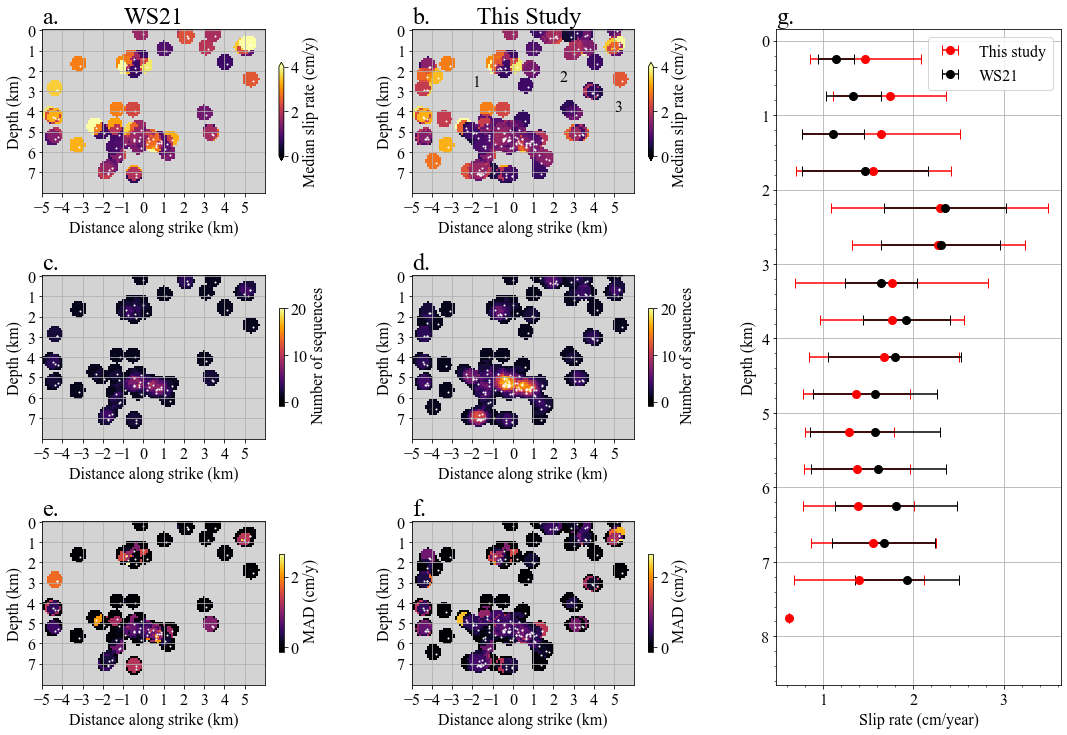

In [99]:
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 16})

# Create a 3x3 grid layout using gridspec
# Define new points for interpolation
x_new = np.arange(x_min, x_max + overlap_distance_x, .1) ## 100 m bins
y_new = np.arange(y_min, y_max
                    + overlap_distance_y, .1)

ss = 1



fig = plt.figure(figsize=(width_l+10,height_m+3))
gs = gridspec.GridSpec(3, 4)

plt.subplots_adjust(wspace=0.3,hspace=0.5)

# Create subplots using the grid layout
ax0 = plt.subplot(gs[0, 0])  # Median; old
ax1 = plt.subplot(gs[0, 1])  # Median; new
ax2 = plt.subplot(gs[0:3, 2])    # Median with depth

ax3 = plt.subplot(gs[1, 0])  # Num; old
ax4 = plt.subplot(gs[1, 1])  # Num; new

ax5 = plt.subplot(gs[2, 0])  # MAD; old
ax6 = plt.subplot(gs[2, 1])  # MAD; new



# Set equal aspect ratio for specific subplots
for ax in [ax0, ax1, ax3, ax4, ax5, ax6]:
    ax.set_aspect(1)

# # Customize aspect ratio for specific subplots
# ax2.set_aspect('auto')  # Customize for specific subplot(s)





ss = 1



# ######################################################################        
##### Cat WS21: Median slip rate #######        
######################################################################



# Interpolation functions:
nan_map = np.zeros_like( c1_tot )
nan_map[ np.isnan(c1_tot) ] = 1

filled_z = c1_tot.copy()
filled_z[ np.isnan(c1_tot) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax0.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);




ax0.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax0.invert_yaxis()
ax0.set_xlabel('Distance along strike (km)')
ax0.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax0,label='Median slip rate (cm/y)',extend='both',shrink=.6)#,boundaries=range(7))
# fig.set_clim(0,np.nanmax(c_tot))
fig.set_clim(0,4)


######################################################################        
##### Cat This Study: Avg Sliprate #######        
######################################################################

# Interpolation functions:
nan_map = np.zeros_like( c_tot )
nan_map[ np.isnan(c_tot) ] = 1

filled_z = c_tot.copy()
filled_z[ np.isnan(c_tot) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan
z_depth_median = np.nanmedian(z_new,1)

fig = ax1.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);



ax1.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax1.invert_yaxis()
ax1.set_xlabel('Distance along strike (km)')
ax1.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax1,label='Median slip rate (cm/y)',extend='both',shrink=.6)#,boundaries=range(10)
# fig.set_clim(0,np.nanmax(c_tot))
fig.set_clim(0,4)


######################################################################        
##### Cat WS21: NUmber of sequences #######        
######################################################################




# Interpolation functions:
nan_map = np.zeros_like( c1_tot_num )
nan_map[ np.isnan(c1_tot_num) ] = 1

filled_z = c1_tot_num.copy()
filled_z[ np.isnan(c1_tot_num) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax3.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno,vmin=0);


ax3.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax3.invert_yaxis()
ax3.set_xlabel('Distance along strike (km)')
ax3.set_ylabel('Depth (km)')#, fontsize=24)
colorbar = plt.colorbar(fig,ax=ax3,label='Number of sequences',extendrect=True,extend='min',shrink=.6)#,ticks=[1,5,10,15,20])#,boundaries=range(10))
fig.set_clim(0,np.nanmax(c_tot_num))



######################################################################        
##### Cat This Study: Number of Sequences #######        
######################################################################
# Interpolation functions:
nan_map = np.zeros_like( c_tot_num )
nan_map[ np.isnan(c_tot_num) ] = 1

filled_z = c_tot_num.copy()
filled_z[ np.isnan(c_tot_num) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan


# cmap = plt.cm.get_cmap('inferno')
# cmap.set_bad('lightgray')      # color of mask on heatmap
# cmap.set_under('lightgray')    # color of mask on cbar



fig = ax4.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);#cm.inferno


ax4.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax4.invert_yaxis()
ax4.set_xlabel('Distance along strike (km)')
ax4.set_ylabel('Depth (km)')#,fontsize=24)
colorbar = plt.colorbar(fig,ax=ax4,label='Number of sequences',extendrect=True,extend='min',shrink=.6)#,ticks=[1,5,10,15,20])#,boundaries=range(10))
fig.set_clim(0,np.nanmax(c_tot_num))


######################################################################        
##### Cat WS21: MAD sliprate #######        
######################################################################


# Interpolation functions:
nan_map = np.zeros_like( c1_tot_MAD )
nan_map[ np.isnan(c1_tot_MAD) ] = 1

filled_z = c1_tot_MAD.copy()
filled_z[ np.isnan(c1_tot_MAD) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax5.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);



ax5.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax5.invert_yaxis()
ax5.set_xlabel('Distance along strike (km)')
ax5.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax5,label='MAD (cm/y)',extendrect=True,extend='min',shrink=.6)
fig.set_clim(0,np.nanmax(c1_tot_MAD))



######################################################################        
##### Cat This Study: Sliprate MAD #######        
######################################################################



# Interpolation functions:
nan_map = np.zeros_like( c_tot_MAD )
nan_map[ np.isnan(c_tot_MAD) ] = 1

filled_z = c_tot_MAD.copy()
filled_z[ np.isnan(c_tot_MAD) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan




fig = ax6.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);


ax6.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax6.invert_yaxis()
ax6.set_xlabel('Distance along strike (km)')
ax6.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax6,label='MAD (cm/y)',extendrect=True,extend='min',shrink=.6)
fig.set_clim(0,np.nanmax(c1_tot_MAD))


######################################################################        
##### Slip with depth #######        
# ######################################################################


ax2.errorbar(c_Z_med, 
             y_centers, 
             xerr=c_Z_MAD, 
             fmt='o', 
             markersize=8, 
             capsize=5,
            color='r',
            label='This study')

ax2.errorbar(c1_Z_med, 
             y_centers, 
             xerr=c1_Z_MAD, 
             fmt='o', 
             markersize=8, 
             capsize=5,
            color='k',
            label='WS21')


ax2.invert_yaxis()

ax2.set_xlabel('Slip rate (cm/year)')
ax2.set_ylabel('Depth (km)')
ax2.grid('on')

######################################################################        
##### FOrmatting
######################################################################


ax0.set_title('WS21',fontsize=24)
ax1.set_title('  This Study',fontsize=24)



letter_title = ['a.','b.','c.','d.','e.','f.','g.']
for i, ax in enumerate([ax0, ax1, ax3, ax4, ax5, ax6]):
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.arange(x_min, x_max, 1))
    ax.set_yticks(np.arange(y_min, y_max, 1))
    ax.set_facecolor("lightgrey")
    
    ax.set_title(letter_title[i],loc='left',fontsize=24)
    ax.grid('on')
    
    
ax2.set_title('g.',loc='left',fontsize=24)

ax2.minorticks_on()
ax1.text(-2,2.75,'1')
ax1.text(2.3,2.5,'2')
ax1.text(5,4,'3')
ax2.legend(loc='upper right')

plt.savefig(f'../reports/figures/slipRate_depth_density_binsize{bin_size}_searchRAD{search_rad}_OL{overlap}_median_MAD_numEventsGT{minNumEvents}_v2_slide.png')
print(f'slipRate_depth_density_binsize{bin_size}_searchRAD{search_rad}_OL{overlap}_median_MAD')


# Older version

NameError: name 'x_min' is not defined

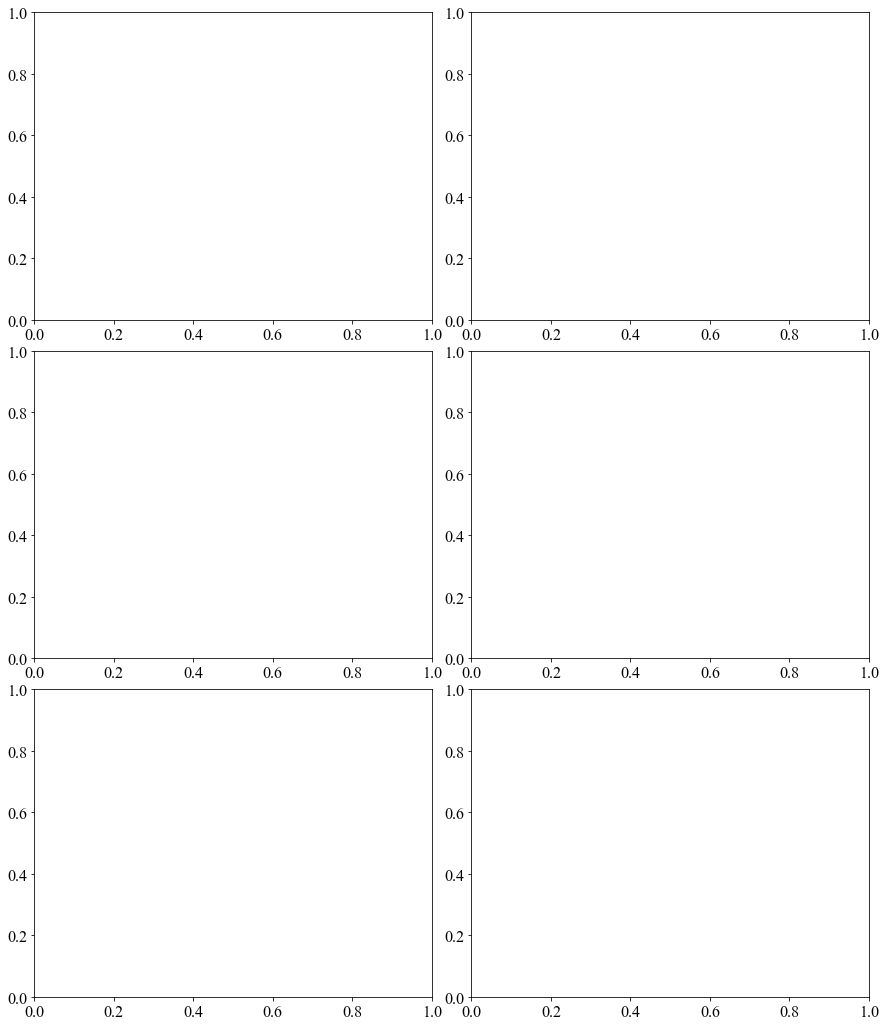

In [67]:

plt.rcParams.update({'font.size': 16})

__, [axA,axB,axC] = plt.subplots(nrows=3,ncols=2,figsize=(width_l,height_l))

plt.subplots_adjust(wspace=.1,hspace=.1)
ax, ax0  = axA  
ax3a,ax2 = axB
ax4, ax3 = axC


# # Define new points for interpolation
# x_new = np.linspace(x_min, x_max + overlap_distance_x, 50) ## 225 m bins
# y_new = np.linspace(y_min, y_max
#                     + overlap_distance_y, 50)

# Define new points for interpolation
x_new = np.arange(x_min, x_max + overlap_distance_x, .1) ## 225 m bins
y_new = np.arange(y_min, y_max
                    + overlap_distance_y, .1)

ss = 1


######################################################################        
##### Cat This Study: Avg Sliprate #######        
######################################################################

# Interpolation functions:
nan_map = np.zeros_like( c_tot )
nan_map[ np.isnan(c_tot) ] = 1

filled_z = c_tot.copy()
filled_z[ np.isnan(c_tot) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax0.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);



ax0.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax0.invert_yaxis()
ax0.set_xlabel('Distance along strike (km)')
ax0.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax0,label='Median slip rate (cm/y)',extendrect=False,extend='max',shrink=.6)#,boundaries=range(10)
# fig.set_clim(0,np.nanmax(c_tot))
fig.set_clim(0,4)


######################################################################        
##### Cat This Study: Number of Sequences #######        
######################################################################
# Interpolation functions:
nan_map = np.zeros_like( c_tot_num )
nan_map[ np.isnan(c_tot_num) ] = 1

filled_z = c_tot_num.copy()
filled_z[ np.isnan(c_tot_num) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan


# cmap = plt.cm.get_cmap('inferno')
# cmap.set_bad('lightgray')      # color of mask on heatmap
# cmap.set_under('lightgray')    # color of mask on cbar



fig = ax2.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);#cm.inferno


ax2.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax2.invert_yaxis()
ax2.set_xlabel('Distance along strike (km)')
ax2.set_ylabel('Depth (km)')#,fontsize=24)
colorbar = plt.colorbar(fig,ax=ax2,label='Number of sequences',shrink=.6)#,ticks=[1,5,10,15,20])#,boundaries=range(10))
fig.set_clim(0,np.nanmax(c_tot_num))




######################################################################        
##### Cat This Study: Sliprate Std #######        
######################################################################



# Interpolation functions:
nan_map = np.zeros_like( c_tot_MAD )
nan_map[ np.isnan(c_tot_MAD) ] = 1

filled_z = c_tot_MAD.copy()
filled_z[ np.isnan(c_tot_MAD) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan




fig = ax3.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);


ax3.scatter(c.dist_along_strike_km,
            c.depth_mean,
            c='w',
            s=ss);

ax3.invert_yaxis()
ax3.set_xlabel('Distance along strike (km)')
ax3.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax3,label='MAD (cm/y)',shrink=.6)
fig.set_clim(0,np.nanmax(c1_tot_MAD))




######################################################################        
##### Cat WS21: Mean Sliparte #######        
######################################################################



# Interpolation functions:
nan_map = np.zeros_like( c1_tot )
nan_map[ np.isnan(c1_tot) ] = 1

filled_z = c1_tot.copy()
filled_z[ np.isnan(c1_tot) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);




ax.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax.invert_yaxis()
ax.set_xlabel('Distance along strike (km)')
ax.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax,label='Median slip rate (cm/y)',extend='max',shrink=.6)#,boundaries=range(7))
# fig.set_clim(0,np.nanmax(c_tot))
fig.set_clim(0,4)
######################################################################        
##### Cat WS21: Number of Sequences #######        
######################################################################




# Interpolation functions:
nan_map = np.zeros_like( c1_tot_num )
nan_map[ np.isnan(c1_tot_num) ] = 1

filled_z = c1_tot_num.copy()
filled_z[ np.isnan(c1_tot_num) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax3a.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno,vmin=0);


ax3a.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax3a.invert_yaxis()
ax3a.set_xlabel('Distance along strike (km)')
ax3a.set_ylabel('Depth (km)')#, fontsize=24)
colorbar = plt.colorbar(fig,ax=ax3a,label='Number of sequences',shrink=.6)#,ticks=[1,5,10,15,20])#,boundaries=range(10))
fig.set_clim(0,np.nanmax(c_tot_num))





######################################################################        
##### Cat WS21: MAD sliprate #######        
######################################################################


# Interpolation functions:
nan_map = np.zeros_like( c1_tot_MAD )
nan_map[ np.isnan(c1_tot_MAD) ] = 1

filled_z = c1_tot_MAD.copy()
filled_z[ np.isnan(c1_tot_MAD) ] = 0

f = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
             np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
             filled_z, kind='linear')

f_nan = interp2d(np.arange(x_min, x_max + overlap_distance_x, bin_size * (1 - overlap)), 
                 np.arange(y_min, y_max + overlap_distance_y, bin_size * (1 - overlap)), 
                 nan_map, kind='linear')     


z_new   =     f(x_new,y_new)
nan_new = f_nan(x_new,y_new)
z_new[ nan_new>0.5 ] = np.nan

fig = ax4.pcolormesh(x_new, y_new, z_new,cmap=cm.inferno);



ax4.scatter(c1.dist_along_strike_km,
            c1.depth_mean,
            c='w',
            s=ss);

ax4.invert_yaxis()
ax4.set_xlabel('Distance along strike (km)')
ax4.set_ylabel('Depth (km)')
colorbar = plt.colorbar(fig,ax=ax4,label='MAD (cm/y)',shrink=.6)
fig.set_clim(0,np.nanmax(c1_tot_MAD))

######################################################################        
##### FOrmatting
######################################################################


ax.set_title('WS21',fontsize=24)
ax0.set_title('  This Study',fontsize=24)
# ax2.set_title('Std slip rate (cm/y)',fontsize=24)


ax0.set_title('b.',loc='left',fontsize=24)
ax.set_title('a.',loc='left',fontsize=24)
ax2.set_title('d.',loc='left',fontsize=24)
ax3a.set_title('c.',loc='left',fontsize=24)
ax3.set_title('f.',loc='left',fontsize=24)
ax4.set_title('e.',loc='left',fontsize=24)


# ax0.axis('equal')
# ax.axis('equal')
# ax2.axis('equal')
# ax3a.axis('equal')
# ax3.axis('equal')
# ax4.axis('equal')

ax0.set_aspect(1)
ax.set_aspect(1)
ax2.set_aspect(1)
ax3a.set_aspect(1)
ax3.set_aspect(1)
ax4.set_aspect(1)

ax0.set_xlim(x_min,x_max)
ax.set_xlim(x_min,x_max)
ax2.set_xlim(x_min,x_max)
ax3a.set_xlim(x_min,x_max)
ax3.set_xlim(x_min,x_max)
ax4.set_xlim(x_min,x_max)



ax0.set_facecolor("lightgrey")
ax.set_facecolor("lightgrey")
ax2.set_facecolor("lightgrey")

ax3.set_facecolor("lightgrey")
ax3a.set_facecolor("lightgrey")
ax4.set_facecolor("lightgrey")

# ax.set_title('Number of sequences')
# ax.set_ylim(ymin=7)

ax0.text(-2,2.75,'1')
ax0.text(2.3,2.5,'2')
ax0.text(5,4,'3')

# plt.savefig(f'../reports/figures/slipRate_depth_density_binsize{bin_size}_searchRAD{search_rad}_OL{overlap}_median_MAD_numEventsGT{minNumEvents}_slide.png')
# print(f'slipRate_depth_density_binsize{bin_size}_searchRAD{search_rad}_OL{overlap}_median_MAD')

# Check for shallow slip rates

In [48]:
depp = .5
np.median(c1[c1.depth_mean<depp].slipRate),stats.median_abs_deviation(c1[c1.depth_mean<depp].slipRate), len(c1[c1.depth_mean<depp].drop_duplicates('RID'))



(0.94700606637721385, 0.044805788847156025, 2)

In [49]:
np.median(c[c.depth_mean<depp].slipRate),stats.median_abs_deviation(c[c.depth_mean<depp].slipRate),len(c[c.depth_mean<depp].drop_duplicates('RID2'))


(0.63975769859962039, 0.092997331681049955, 3)

# Deep slip rates

In [50]:
depp2 = 7
np.median(c1[c1.depth_mean>depp2].slipRate),stats.median_abs_deviation(c1[c1.depth_mean>depp2].slipRate), len(c1[c1.depth_mean>depp2])



(1.6707292310640471, 0.0, 1)

In [51]:
np.median(c[c.depth_mean>depp2].slipRate),stats.median_abs_deviation(c[c.depth_mean>depp2].slipRate),len(c[c.depth_mean>depp2].drop_duplicates('RID2'))



(0.46888512680321087, 0.00076957916382197622, 2)

# Median Slip Rates

In [52]:
np.median(c1.slipRate),stats.median_abs_deviation(c1.slipRate), len(c1)


(1.6314323704737936, 0.72173886120901187, 97)

In [53]:
np.median(c.slipRate),stats.median_abs_deviation(c.slipRate),len(c)


(0.46888512680321087, 0.12775469730116229, 16)

# Distance of study area to other things

In [54]:
lat0,lon0 = np.mean(cat_all.lat),np.mean(cat_all.long)



haversine.haversine((lat0, lon0),(37.04, -121.88),unit='km') # Loma Prieta

97.81678164969651

In [55]:
haversine.haversine((lat0, lon0),(35.899722, -120.432778),unit='km') # Parkfield

83.80125397097198

In [56]:
haversine.haversine((lat0, lon0),(36.380278, -121.002778),unit='km')# Bitterwater

10.536123959812176

In [57]:
haversine.haversine((lat0, lon0),(36.4817,-121.0517),unit='km')# Dry Lake Valley, Burford and Harsh, 2.19 cm/year

1.5613254286719906

In [58]:
haversine.haversine((lat0, lon0),(36.3883,-120.975),unit='km') #Eade Ranch, 3.13 +- .04 cm/yr, Alignment Array


10.920243877523985

In [59]:
haversine.haversine((lat0, lon0),(36.4917,-121.0783),unit='km') #Dry Lake Long, .025 cm/yr, Schultz et al, 1982, Creep Meter


3.9188341335869232

In [60]:
haversine.haversine((lat0, lon0),(36.4917,-121.0783),unit='km') #Dry Lake Long, .025 cm/yr, Schultz et al, 1982, Creep Meter


3.9188341335869232

# Functions

In [ ]:
# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################



# def removeEndedLateRES(cat, endYear = 2015):
    
#     startYear = 1984
    
#     cat_reloc_graded_stats_cont = pd.DataFrame()

#     for cl in np.unique(cat.RID2):
#         df_cl = cat[cat.RID2==cl].copy()

#         time_mean = df_cl.time_mean_yr.iloc[0] *3

#         time_end = df_cl.index[-1] 
#         time_start = df_cl.index[0] 
        

#         if ((time_end.date()+pd.Timedelta(time_mean*365.25,'day')).year >= endYear) and ((time_start.date()-pd.Timedelta(time_mean*365.25,'day')).year <= startYear):



#             cat_reloc_graded_stats_cont = cat_reloc_graded_stats_cont.append(df_cl)

        
#     print(len(cat),len(cat_reloc_graded_stats_cont))
#     print(len(cat)-len(cat_reloc_graded_stats_cont), ' events removed')        
    
#     return cat_reloc_graded_stats_cont  


# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################


# def removeEndedLateRES_RID(cat, endYear = 2015):
    
#     startYear = 1984
    
#     cat_reloc_graded_stats_cont = pd.DataFrame()

#     for cl in np.unique(cat.RID):
#         df_cl = cat[cat.RID==cl].copy()

#         time_mean = df_cl.time_mean_yr.iloc[0] *3

#         time_end = df_cl.index[-1] 
#         time_start = df_cl.index[0] 
        

#         if ((time_end.date()+pd.Timedelta(time_mean*365.25,'day')).year >= endYear) and ((time_start.date()-pd.Timedelta(time_mean*365.25,'day')).year <= startYear):



#             cat_reloc_graded_stats_cont = cat_reloc_graded_stats_cont.append(df_cl)

        
#     print(len(cat),len(cat_reloc_graded_stats_cont))
#     print(len(cat)-len(cat_reloc_graded_stats_cont), ' events removed')        
    
#     return cat_reloc_graded_stats_cont  

# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################


# def plotScatterMapRID_basic(cat_raw, scale = .01,plotNew = 1,ax=None):

#     if ax is None:
#         ax = plt.gca()


#     radii = [scale*calcRadius(m)**2 for m in cat_raw.magnitude]
#     cat_raw['radius'] = radii


#     ## Split into magnitude bins - Background seismicity
#     cat_0 = cat_raw[cat_raw.magnitude<1]

#     cat_1 = cat_raw[cat_raw.magnitude>=1]
#     cat_1 = cat_1[cat_1.magnitude<2]

#     cat_2 = cat_raw[cat_raw.magnitude>=2]
#     cat_2 = cat_2[cat_2.magnitude<3]

#     cat_3 = cat_raw[cat_raw.magnitude>=3]



#     #Background
#     s0=1
#     s1=10
#     s2=100
#     s3=500


#     ax.scatter(cat_0.long, cat_0.lat,edgecolor='steelblue',facecolor='None',s=s0,label='Mw0')
#     ax.scatter(cat_1.long, cat_1.lat,edgecolor='steelblue',facecolor='None',s=s1,label='Mw1')
#     ax.scatter(cat_2.long, cat_2.lat,edgecolor='steelblue',facecolor='None',s=s2,label='Mw2')
#     ax.scatter(cat_3.long, cat_3.lat,edgecolor='steelblue',facecolor='None',s=s3,label='Mw3')

#     ax.grid('on')

    

# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################

# def plotScatterMapRID(cat_raw, scale = .01,plotNew = 1,ax=None):

#     if ax is None:
#         ax = plt.gca()


#     radii = [scale*calcRadius(m)**2 for m in cat_raw.magnitude]
#     cat_raw['radius'] = radii

#     cat = pd.DataFrame()

#     for clus in cat_raw.drop_duplicates('RID').RID[1:]: #skip first for 9999
#         df = cat_raw[cat_raw.RID==clus]
#         medlat = np.median(df.lat)
#         medlong = np.median(df.long)        
#         medmag = np.median(df.magnitude)   
#         cat = cat.append({'RID':clus,
#                           'lat':medlat,
#                            'long':medlong,
#                            'magnitude':medmag},
#                           ignore_index=True)
                
    
#     cat = cat.append(cat_raw[cat_raw.RID=='9999'])
    
#     cat_rep = cat[cat.RID!='0']
#     cat_rep = cat_rep[cat_rep.RID!='9999']
#     cat_new_raw = cat_raw[cat_raw.RID=='0']
#     cat_BG = cat_raw[cat_raw.RID=='9999']
    
#     cat_new = pd.DataFrame()
#     print('cat_new_raw',len(cat_new_raw))
#     print('cat_new_raw',len(cat_new_raw.drop_duplicates('RID2')))

#     for clus in cat_new_raw.drop_duplicates('RID2').RID2: 
#         df = cat_new_raw[cat_new_raw.RID2==clus]
#         medlat = np.median(df.lat)
#         medlong = np.median(df.long)        
#         medmag = np.median(df.magnitude)   
#         cat_new = cat_new.append({'RID2':clus,
#                           'lat':medlat,
#                            'long':medlong,
#                            'magnitude':medmag},
#                           ignore_index=True)

#     print('cat_new',len(cat_new))

#     ## Split into magnitude bins - Background seismicity
#     cat_0 = cat_BG[cat_BG.magnitude<1]

#     cat_1 = cat_BG[cat_BG.magnitude>=1]
#     cat_1 = cat_1[cat_1.magnitude<2]

#     cat_2 = cat_BG[cat_BG.magnitude>=2]
#     cat_2 = cat_2[cat_2.magnitude<3]

#     cat_3 = cat_BG[cat_BG.magnitude>=3]


#     ## Split into magnitude bins - RES seismicity
#     cat_rep_0 = cat_rep[cat_rep.magnitude<1]

#     cat_rep_1 = cat_rep[cat_rep.magnitude>=1]
#     cat_rep_1 = cat_rep_1[cat_rep_1.magnitude<2]

#     cat_rep_2 = cat_rep[cat_rep.magnitude>=2]
#     cat_rep_2 = cat_rep_2[cat_rep_2.magnitude<3]

#     cat_rep_3 = cat_rep[cat_rep.magnitude>=3]
    
    
#     ## Split into magnitude bins - NEW seismicity
#     cat_new_0 = cat_new[cat_new.magnitude<1]

#     cat_new_1 = cat_new[cat_new.magnitude>=1]
#     cat_new_1 = cat_new_1[cat_new_1.magnitude<2]

#     cat_new_2 = cat_new[cat_new.magnitude>=2]
#     cat_new_2 = cat_new_2[cat_new_2.magnitude<3]

#     cat_new_3 = cat_new[cat_new.magnitude>=3]    




#     #Background
#     s0=1
#     s1=10
#     s2=100
#     s3=500


#     ax.scatter(cat_0.long, cat_0.lat,edgecolor='grey',facecolor='None',s=s0,label='Mw0')
#     ax.scatter(cat_1.long, cat_1.lat,edgecolor='grey',facecolor='None',s=s1,label='Mw1')
#     ax.scatter(cat_2.long, cat_2.lat,edgecolor='grey',facecolor='None',s=s2,label='Mw2')
#     ax.scatter(cat_3.long, cat_3.lat,edgecolor='grey',facecolor='None',s=s3,label='Mw3')
    
#     ax.scatter(cat_rep_0.long, cat_rep_0.lat,edgecolor='b',facecolor='None',s=s0)
#     ax.scatter(cat_rep_1.long, cat_rep_1.lat,edgecolor='b',facecolor='None',s=s1)
#     ax.scatter(cat_rep_2.long, cat_rep_2.lat,edgecolor='b',facecolor='None',s=s2)
#     ax.scatter(cat_rep_3.long, cat_rep_3.lat,edgecolor='b',facecolor='None',s=s3)
    
#     if plotNew:
#         ax.scatter(cat_new_0.long, cat_new_0.lat,edgecolor='r',facecolor='None',s=s0)
#         ax.scatter(cat_new_1.long, cat_new_1.lat,edgecolor='r',facecolor='None',s=s1)
#         ax.scatter(cat_new_2.long, cat_new_2.lat,edgecolor='r',facecolor='None',s=s2)
#         ax.scatter(cat_new_3.long, cat_new_3.lat,edgecolor='r',facecolor='None',s=s3)  
    

    
  

#     ax.grid('on')


# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################

    
# def rotateMapView(cat,angle,lat0,lon0):

#     lat = cat.lat
#     lon = cat.long

#     dlat = lat - lat0
#     dlon = lon - lon0

#     y= dlat*111.1949;
#     x= dlon*np.cos(lat*np.pi/180)*111.1949;

#     # dlat and dlon being the difference between lat/lon origin and earthquake epicenter. 
#     # lat is the latitude of the earthquake location (since longitude is latitude dependent). 

#     #Then rotate, with PHI being the angle you like to rotate about (clockwise from north):
#     phiA= (angle-90)*np.pi/180;

#     # then plot distance along fault vs. depth: 
#     xx= x * np.cos(phiA)- y * np.sin(phiA)

# #     cat['dist_along_strike_km'] = xx
#     # plt.scatter(xx,cat.depth_km)
    
#     return xx

# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################


# def plotScatterMapDepthAlongStrikeRID(cat_raw,lat0,lon0,angle = 48, scale = .01,plotNew=1,ax=None):

#     if ax is None:
#         ax = plt.gca()

#     cat_raw['dist_along_strike_km'] = rotateMapView(cat_raw,angle,lat0,lon0)

        
#     radii = [scale*calcRadius(m)**2 for m in cat_raw.magnitude]
#     cat_raw['radius'] = radii
    
#     cat = pd.DataFrame()

#     for clus in cat_raw.drop_duplicates('RID').RID[1:]: #skip first for 9999
#         df = cat_raw[cat_raw.RID==clus]
#         medDepth = np.median(df.depth_km)
#         medDistAlongStrike = np.median(df.dist_along_strike_km)        
#         medmag = np.median(df.magnitude)   
#         cat = cat.append({'RID':clus,
#                           'depth_km':medDepth,
#                            'dist_along_strike_km':medDistAlongStrike,
#                            'magnitude':medmag},
#                           ignore_index=True)

    
#     cat = cat.append(cat_raw[cat_raw.RID=='9999'])

#     #Get already cataloged REQS
#     cat_rep = cat[cat.RID!='0']
#     cat_rep = cat_rep[cat_rep.RID!='9999']
#     cat_new_raw = cat_raw[cat_raw.RID=='0']
#     cat_BG = cat_raw[cat_raw.RID=='9999']
    
#     cat_new = pd.DataFrame()


#     for clus in cat_new_raw.drop_duplicates('RID2').RID2: 
#         df = cat_new_raw[cat_new_raw.RID2==clus]
#         medDepth = np.median(df.depth_km)
#         medDistAlongStrike = np.median(df.dist_along_strike_km)       
#         medmag = np.median(df.magnitude)   
#         cat_new = cat_new.append({'RID2':clus,
#                           'depth_km':medDepth,
#                            'dist_along_strike_km':medDistAlongStrike,
#                            'magnitude':medmag},
#                           ignore_index=True)


#     ## Split into magnitude bins - Background seismicity
#     cat_0 = cat_BG[cat_BG.magnitude<1]

#     cat_1 = cat_BG[cat_BG.magnitude>=1]
#     cat_1 = cat_1[cat_1.magnitude<2]

#     cat_2 = cat_BG[cat_BG.magnitude>=2]
#     cat_2 = cat_2[cat_2.magnitude<3]

#     cat_3 = cat_BG[cat_BG.magnitude>=3]


#     ## Split into magnitude bins - RES seismicity
#     cat_rep_0 = cat_rep[cat_rep.magnitude<1]

#     cat_rep_1 = cat_rep[cat_rep.magnitude>=1]
#     cat_rep_1 = cat_rep_1[cat_rep_1.magnitude<2]

#     cat_rep_2 = cat_rep[cat_rep.magnitude>=2]
#     cat_rep_2 = cat_rep_2[cat_rep_2.magnitude<3]

#     cat_rep_3 = cat_rep[cat_rep.magnitude>=3]



#     ## Split into magnitude bins - RES seismicity
#     cat_new_0 = cat_new[cat_new.magnitude<1]

#     cat_new_1 = cat_new[cat_new.magnitude>=1]
#     cat_new_1 = cat_new_1[cat_new_1.magnitude<2]

#     cat_new_2 = cat_new[cat_new.magnitude>=2]
#     cat_new_2 = cat_new_2[cat_new_2.magnitude<3]

#     cat_new_3 = cat_new[cat_new.magnitude>=3]
#     #Background
#     s0=1
#     s1=10
#     s2=100
#     s3=500


#     ax.scatter(cat_0.dist_along_strike_km, cat_0.depth_km,edgecolor='gray',facecolor='None',s=s0,label='Mw0')
#     ax.scatter(cat_1.dist_along_strike_km, cat_1.depth_km,edgecolor='gray',facecolor='None',s=s1,label='Mw1')
#     ax.scatter(cat_2.dist_along_strike_km, cat_2.depth_km,edgecolor='gray',facecolor='None',s=s2,label='Mw2')
#     ax.scatter(cat_3.dist_along_strike_km, cat_3.depth_km,edgecolor='gray',facecolor='None',s=s3,label='Mw3')
    
#     ax.scatter(cat_rep_0.dist_along_strike_km, cat_rep_0.depth_km,edgecolor='b',facecolor='None',s=s0)
#     ax.scatter(cat_rep_1.dist_along_strike_km, cat_rep_1.depth_km,edgecolor='b',facecolor='None',s=s1)
#     ax.scatter(cat_rep_2.dist_along_strike_km, cat_rep_2.depth_km,edgecolor='b',facecolor='None',s=s2)
#     ax.scatter(cat_rep_3.dist_along_strike_km, cat_rep_3.depth_km,edgecolor='b',facecolor='None',s=s3)
    
#     if plotNew:
#         ax.scatter(cat_new_0.dist_along_strike_km, cat_new_0.depth_km,edgecolor='r',facecolor='None',s=s0)
#         ax.scatter(cat_new_1.dist_along_strike_km, cat_new_1.depth_km,edgecolor='r',facecolor='None',s=s1)
#         ax.scatter(cat_new_2.dist_along_strike_km, cat_new_2.depth_km,edgecolor='r',facecolor='None',s=s2)
#         ax.scatter(cat_new_3.dist_along_strike_km, cat_new_3.depth_km,edgecolor='r',facecolor='None',s=s3)   
    

 

#     ax.grid('on')
#     ax.invert_yaxis()
    
#     return cat


# ##################################################################################################
# # .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo
# ##################################################################################################


# def plotCumul5(cat_clust,size=50,ax=None):
    
#     if ax is None:
#         ax = plt.gca()
        
    
#     cat_clust = cat_clust.sort_index()   
#     cumsum = [i for i in range(1,len(cat_clust)+1)]
#     dates = [pd.to_datetime(d) for d in cat_clust.index]    
    
#     cat_clust_old = cat_clust[cat_clust.RID!='0'].sort_index()   
#     cumsum_old = [i for i in range(1,len(cat_clust_old)+1)]
#     dates_old = [pd.to_datetime(d) for d in cat_clust_old.index]

    
#     cat_clust_new = cat_clust[cat_clust.RID=='0'].sort_index()   
#     cumsum_new = [i for i in range(1,len(cat_clust_new)+1)]
#     dates_new = [pd.to_datetime(d) for d in cat_clust_new.index]

#     ax.step(dates, cumsum,color='k',where='post')
#     ax.scatter(dates, cumsum,c='k',s=size)
        
#     ax.set_ylabel('Cumalitive number of earthquakes')    

#     ax.tick_params(axis='x', labelrotation = 90,size=10) 
    
#     ax.set_ylim(ymin=0)
    
#     ax.grid('on')
        

# Print catalog 

In [ ]:
len(cat2_stats_cont)

In [ ]:
isRESp = np.zeros([len(cat_all),1])
cat_all['isRESp'] = isRESp

isRESpID = cat_all[cat_all.event_ID.isin(cat2_stats_cont.event_ID)]

cat_all[cat_all.event_ID.isin(isRESpID.event_ID)].isRESp = 1

In [ ]:
np.unique(cat_all.isRESp)

In [ ]:

# Create an array of zeros with the same length as 'cat_all'
isRESp = np.zeros(len(cat_all))

# Add the 'isRESp' array as a new column in the 'cat_all' DataFrame
cat_all['isRESp'] = isRESp

# Select event IDs from 'cat2_stats_cont'
isRESpID = cat2_stats_cont['event_ID']

# Set the 'isRESp' column to 1 for rows with matching event IDs
cat_all.loc[cat_all['event_ID'].isin(isRESpID), 'isRESp'] = 1



columns_new = ["YR", "MO", "DY", "HR", "MN", "SC", "DAYS", "LAT", "LON", "DEP", "EX", "EY", "EZ", "MAG", "DMAG", "DMAGE", "CCm", "evID"]

cat_all_reformat = pd.DataFrame({
                                "YR": cat_all.YR,
                                "MO": cat_all.MO,
                                "DY": cat_all.DY,
                                "HR": cat_all.HR,
                                "MN": cat_all.MI,
                                "SC": cat_all.SC,
                                "LAT": cat_all.lat,
                                "LON": cat_all.long,
                                "DEP": cat_all.depth_km,
                                "EX": cat_all.dX,
                                "EY": cat_all.dY,
                                "EZ": cat_all.dZ,
                                "MAG": cat_all.magnitude,
                                "evID": cat_all.event_ID,
                                "seqID":cat_all.RID2,
                                "isRESp":cat_all.isRESp
                            })




cat_all_reformat.set_index("evID", inplace=True)

In [ ]:
cat_all_reformat.to_csv('../data/catalogs/TSR_SawiEtAl2023_RES_SUPP.csv', sep = '\t')